# Clustering Conformations using Python Libraries


## Import dependencies

In [8]:
import numpy as np
import pickle
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list, to_tree, centroid, cut_tree,fcluster
from matplotlib import pyplot as plt
from helper import info, threshold_remove, multirun
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

<style type='text/css'>
.CodeMirror{
    font-size: 12px;
}

div.output_area pre {
    font-size: 12px;
}
</style>

### Isolate lists with missing residues beyond a threshold

#### threshold_remove(threshold, segments = None)
#### Parameters:
##### threshold, 
minimum number of missing residues before discarded, all conformations with missing residues ≥ threshold are discarded.
Segments, default None analyzes the complete sequence for missing residues.
Otherwise takes in a list of tuples (start, end) residue indices using zero indexing.

This method is for the purpose of threshold vs missclassification analysis. In this case the full length is kept since the whole chains_list will be analyzed regardless of the amount of missing indices.

In [12]:
threshold_remove(threshold=297, segments=[(0,296)])

Threshold: 297 amount removed: 0


## Load presorted classification based on annotations list

In [9]:
#@ open files
with open("chains_list.var","rb") as chains_list_var:
   chains_list = pickle.load(chains_list_var)
   chains_list_var.close()
#print(f"chains_list: {chains_list}")
with open("structures/opened_active.var", "rb") as open_active_var:
    open_active_list = pickle.load(open_active_var)
    open_active_var.close()
with open("structures/closed_inactive.var", "rb") as closed_inactive_var:
    closed_inactive_list = pickle.load(closed_inactive_var)
    closed_inactive_var.close()
with open("structures/opened_inactive.var", "rb") as open_inactive_var:
    open_inactive_list = pickle.load(open_inactive_var)
    open_inactive_var.close()

print(f"open_active: {len(open_active_list)}")
print(f"closed_inactive: {len(closed_inactive_list)}")
print(f"open_inactive: {len(open_inactive_list)}")
annotated_dict_list_codes= {"open_active": open_active_list, "closed_inactive": closed_inactive_list, "open_inactive": open_inactive_list} #dictionary of codes list
annotated_dict_list ={"open_active": list(), "closed_inactive": list(), "open_inactive": list()} #dictionary of list of indices
for i,conformation in enumerate(chains_list):
    for j,l in enumerate(annotated_dict_list_codes):
        if conformation in annotated_dict_list_codes[l]:
            #print(f"l: {l}")
            annotated_dict_list[l].append(i)
#print(f"annotated_dict_list: {annotated_dict_list_codes}")


open_active: 162
closed_inactive: 277
open_inactive: 92


### Open calculated rms matrix and chains list
#### matrix.var
Calculated rms matrix from aligning all of the choice conformation chosen by best_align.py and calculated by pml_script_all.py.
#### chains_list.var
Generated by reading through the dictionary of annotated conformations and making a list of chains of the conformation. This will give the labeling order of the rms matrix obtained since pml_script_all.py iterated through this list

In [1]:
with open("matrix.var", "rb") as matrix_var:
   matrix = (pickle.load(matrix_var))
   matrix_var.close()

#print(f"matrix: {matrix}")
with open("matrix_AB.var", "rb") as matrix_AB_var:
   matrix_AB = (pickle.load(matrix_AB_var))
   matrix_AB_var.close()
with open("matrix_seg.var", "rb") as matrix_seg_var:
   matrix_seg = pickle.load(matrix_seg_var)
   matrix_seg_var.close()

NameError: name 'pickle' is not defined

### Ward's Algorithm
A linkage with minimum variance method. We define 
$$
T = |v| + |s| + |t|
$$
As the cardinality the forest _u_ and _v_ combined
Given the distance function is computed recursively with the equation:
$$
d[i][j] = d(i,j) = \sqrt{\frac{|v| + |s|}{T}d(v,s)^2 + \frac{|v| + |t|}{T}d(v,t)^2 - \frac{|v|}{T}d(s,t)^2}
$$
The merging cost, of which ward's algorithm tries to minimize the growth is defined as follows:
$$
Cost(u,v) = \frac{|u||v|}{|u| +|v|}||c_u - c_v ||^2
$$
$c_i$ is the vector of the centroid. And the derivation comes from the distance sum union of the two sets together minus the distance sum of the individual sets. 
<br>
It considers the case of merging and then calculates the variance from the centroid of the final merged cluster as the distance

## Info function:
 ```info(matrix,title,chains_list,annotated_dict_list,complete=True,kernel="linear",hierarchy_method = None, no_clusters=3, dist_metric = "euclidean", tsne= False, auto_cut_tree = True)```
### Usage:
### __Required Parameters__:
#### matrix:
    A matrix of values where each row represents a conformation and the features along the columns
    In this case we have RMSD of all the CA, RMSD of all CA + CB, RSMD of all CA of specific segments
#### title: 
    Title of the matrix for plotting purposes
#### chains_list:
    List chains/ conformations in the same order as the matrix
#### annotated_dict_list:
    Dictionary where each key is group classified, found by pdb file annotation and value is a list of indices of the conformations on the matrix
#### complete:
    For the purposes of identifying the coincidence of misclassification and missing residues beyond a certain threshold. Complete is a boolean, if True it will use the full matrix of data. Else if false, that means chains_list is reduced_chains_list (a shorter chain where every conformation has less than threshold missing residues as defined by the last run threshold_reduce function)
    <b> if threshold_removed was called and removed any conformations and input chains_list is a reduced_chains_list then set this to true</b>
### __Optional Parameters__:
#### kernel:
    For the use of PCA, Kernel method of PCA (if in use)
#### Hierarchy_method:
    Method of hierachical clustering, default is None. set to None then the function will use the graph for Kmeans clustering by default. Uses sklearn and scipy hierarchy clustering. 
    Choices: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’}
#### no_clusters:
    Number of clusters to be found. However, the statistics will give an error if the amount of clusters and the length of the ```annotated_dict_list``` do not match
#### dist_metric:
    Distance metric for hierarchical clustering, by default euclidean
#### tsne:
    Data is visualized in 2 different ways T-SNE and PCA, By default tsne = False means PCA is used. Data is projected into 2 dimensions
#### auto_cut_tree:
    By default the tree will be automatically cut by the number of clusters, however, if set to False, manual cutting will ask the user to get left or right tree in a sequence from top down.
    The first choice will prompt the user for the leftmost tree and then the second choice for the middle tree.
    Use the calculated dendrogram to decide on the manual tree partitioning.
    Use: "left", "l", "right", or "r"
    The statistics will give an erroneous result if the middle tree, the second tree is chosen not to the immediate right of the first tree.



## Experiment 1:
No missing residues, T-SNE projection with Ward's algorithm to obtain 3 clusters.

shape: (531, 2)
type X: <class 'numpy.ndarray'>,  type - ax1[0]: <class 'numpy.float32'> axis1.tolist()[0]: ()


/Users/yao/Desktop/dkp/Work/internship1_bioinfo/helper.py:602: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = linkage(matrix, method = hierarchy_method, metric = dist_metric)


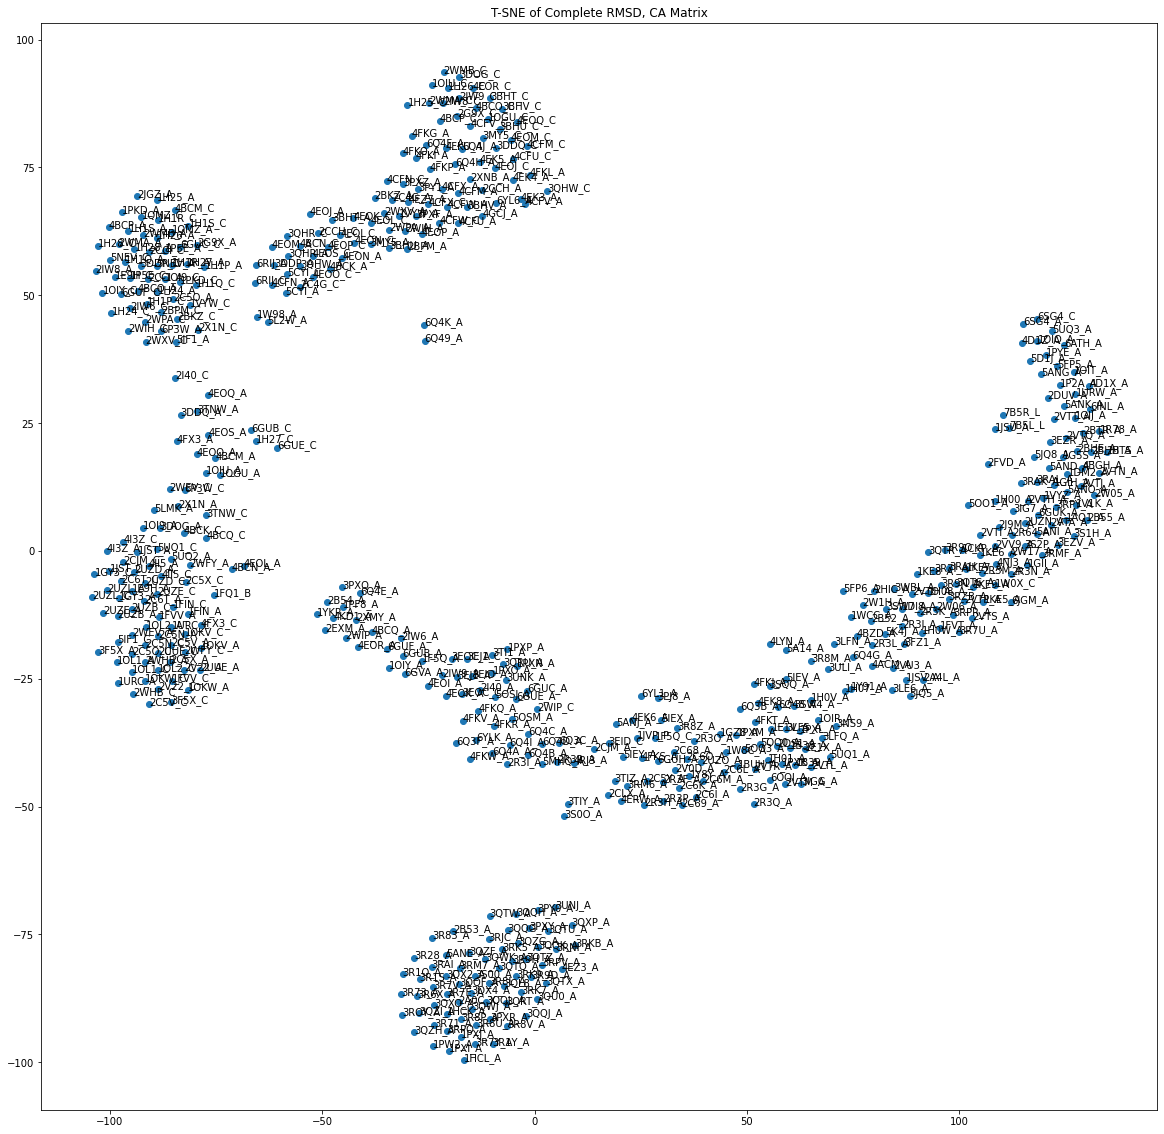

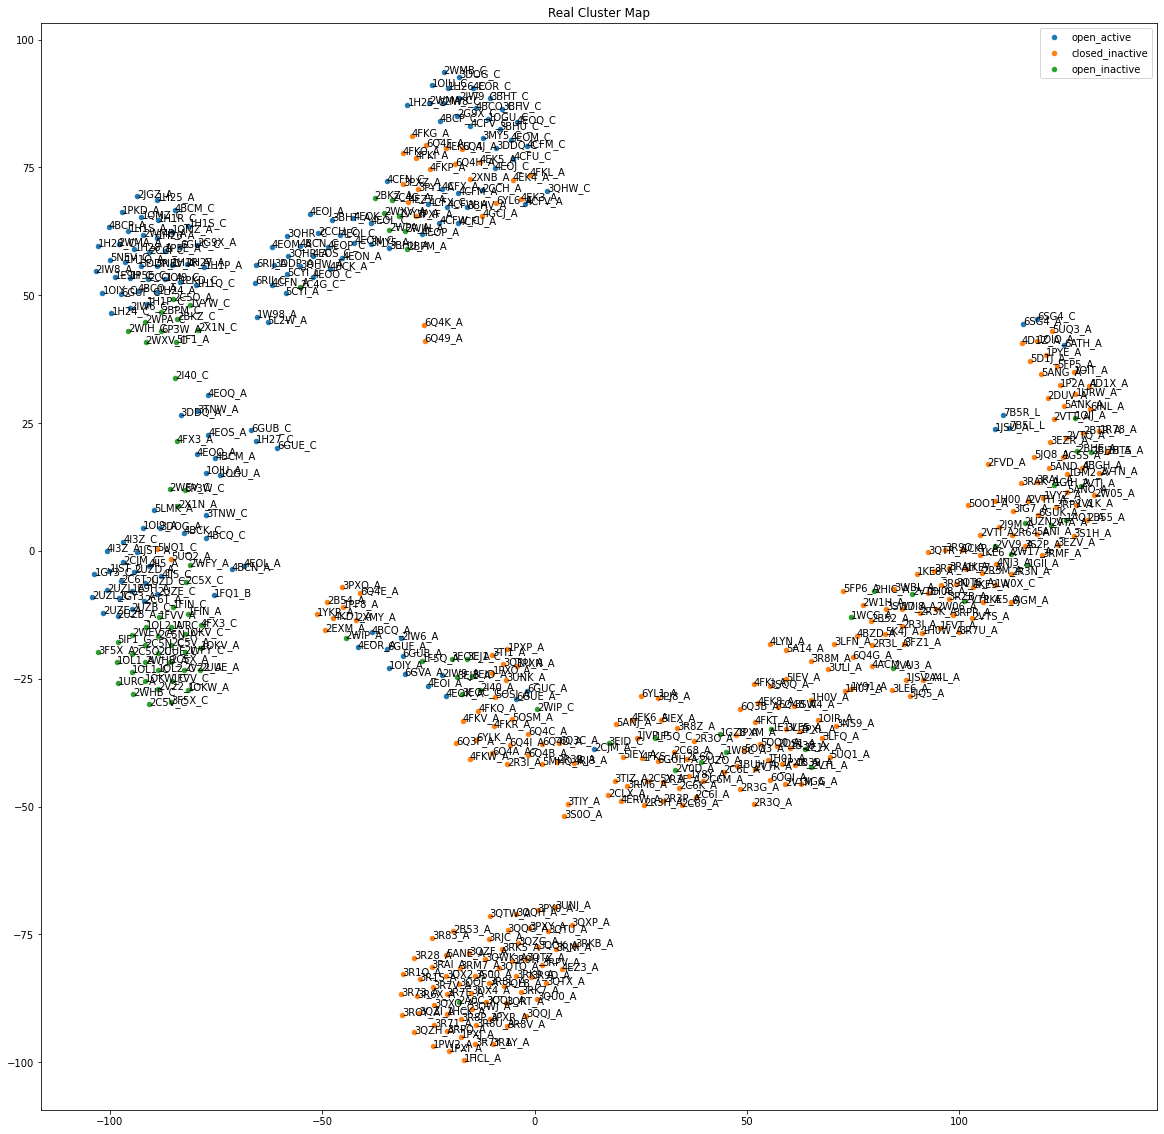

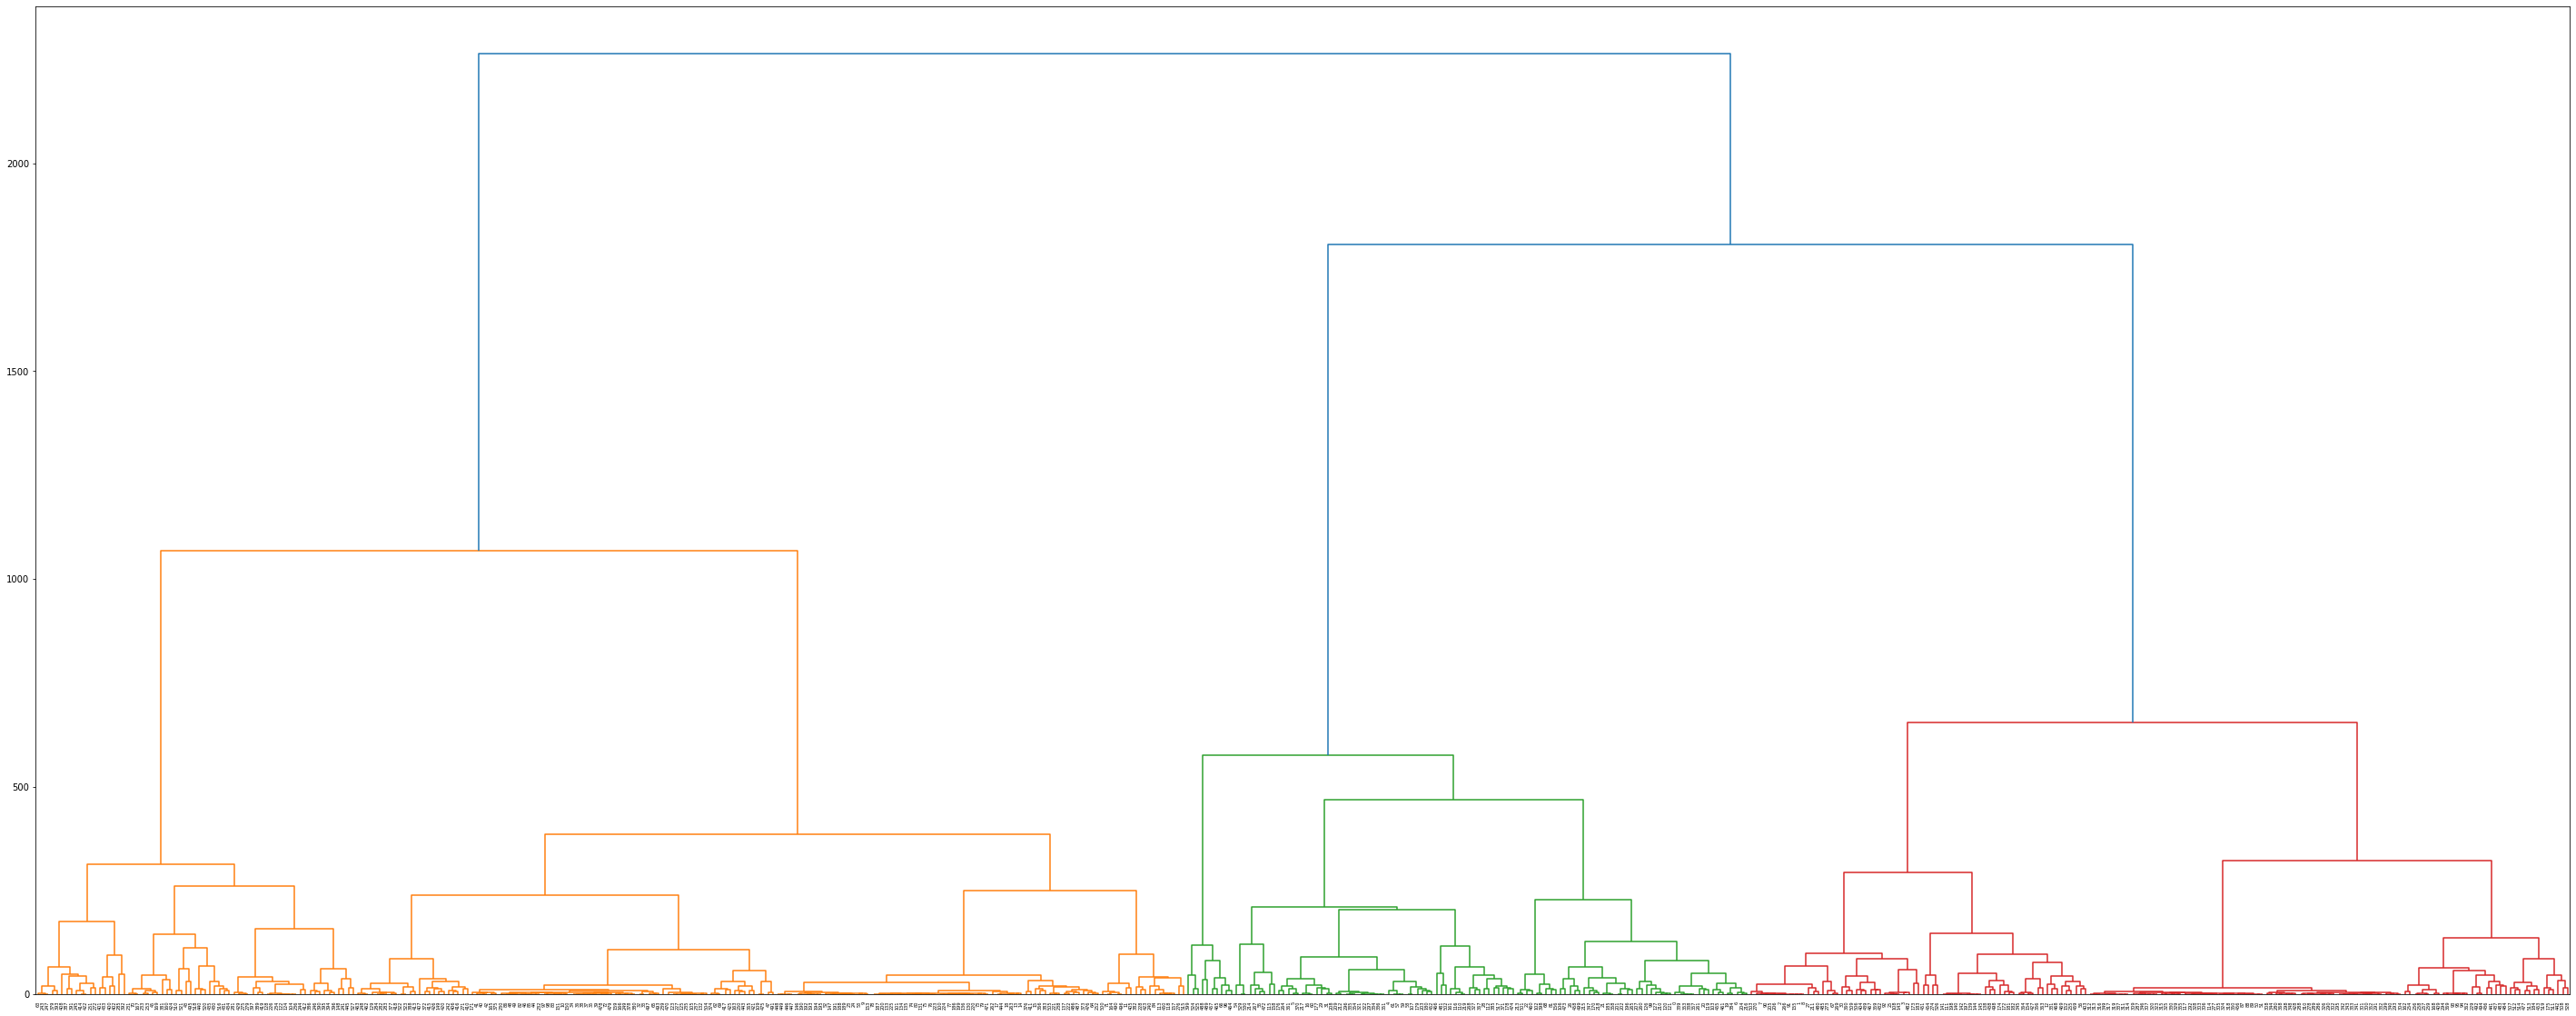

Dendrogram plotted
------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 118
cluster 1, length: 172
cluster 2, length: 241
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
open_inactive     0.135593  0.173913  0.152381
closed_inactive   0.872093  0.541516  0.668151
open_active       0.626556  0.932099  0.749380
Averages          0.544747  0.549176  0.523304
out:
                            Real open_inactive  Real closed_inactive  Real open_active
Predicted open_inactive                    16                    96                 6
Predicted closed_inactive                  17                   150                 5
Predicted open_active                      59                    31               151
---------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


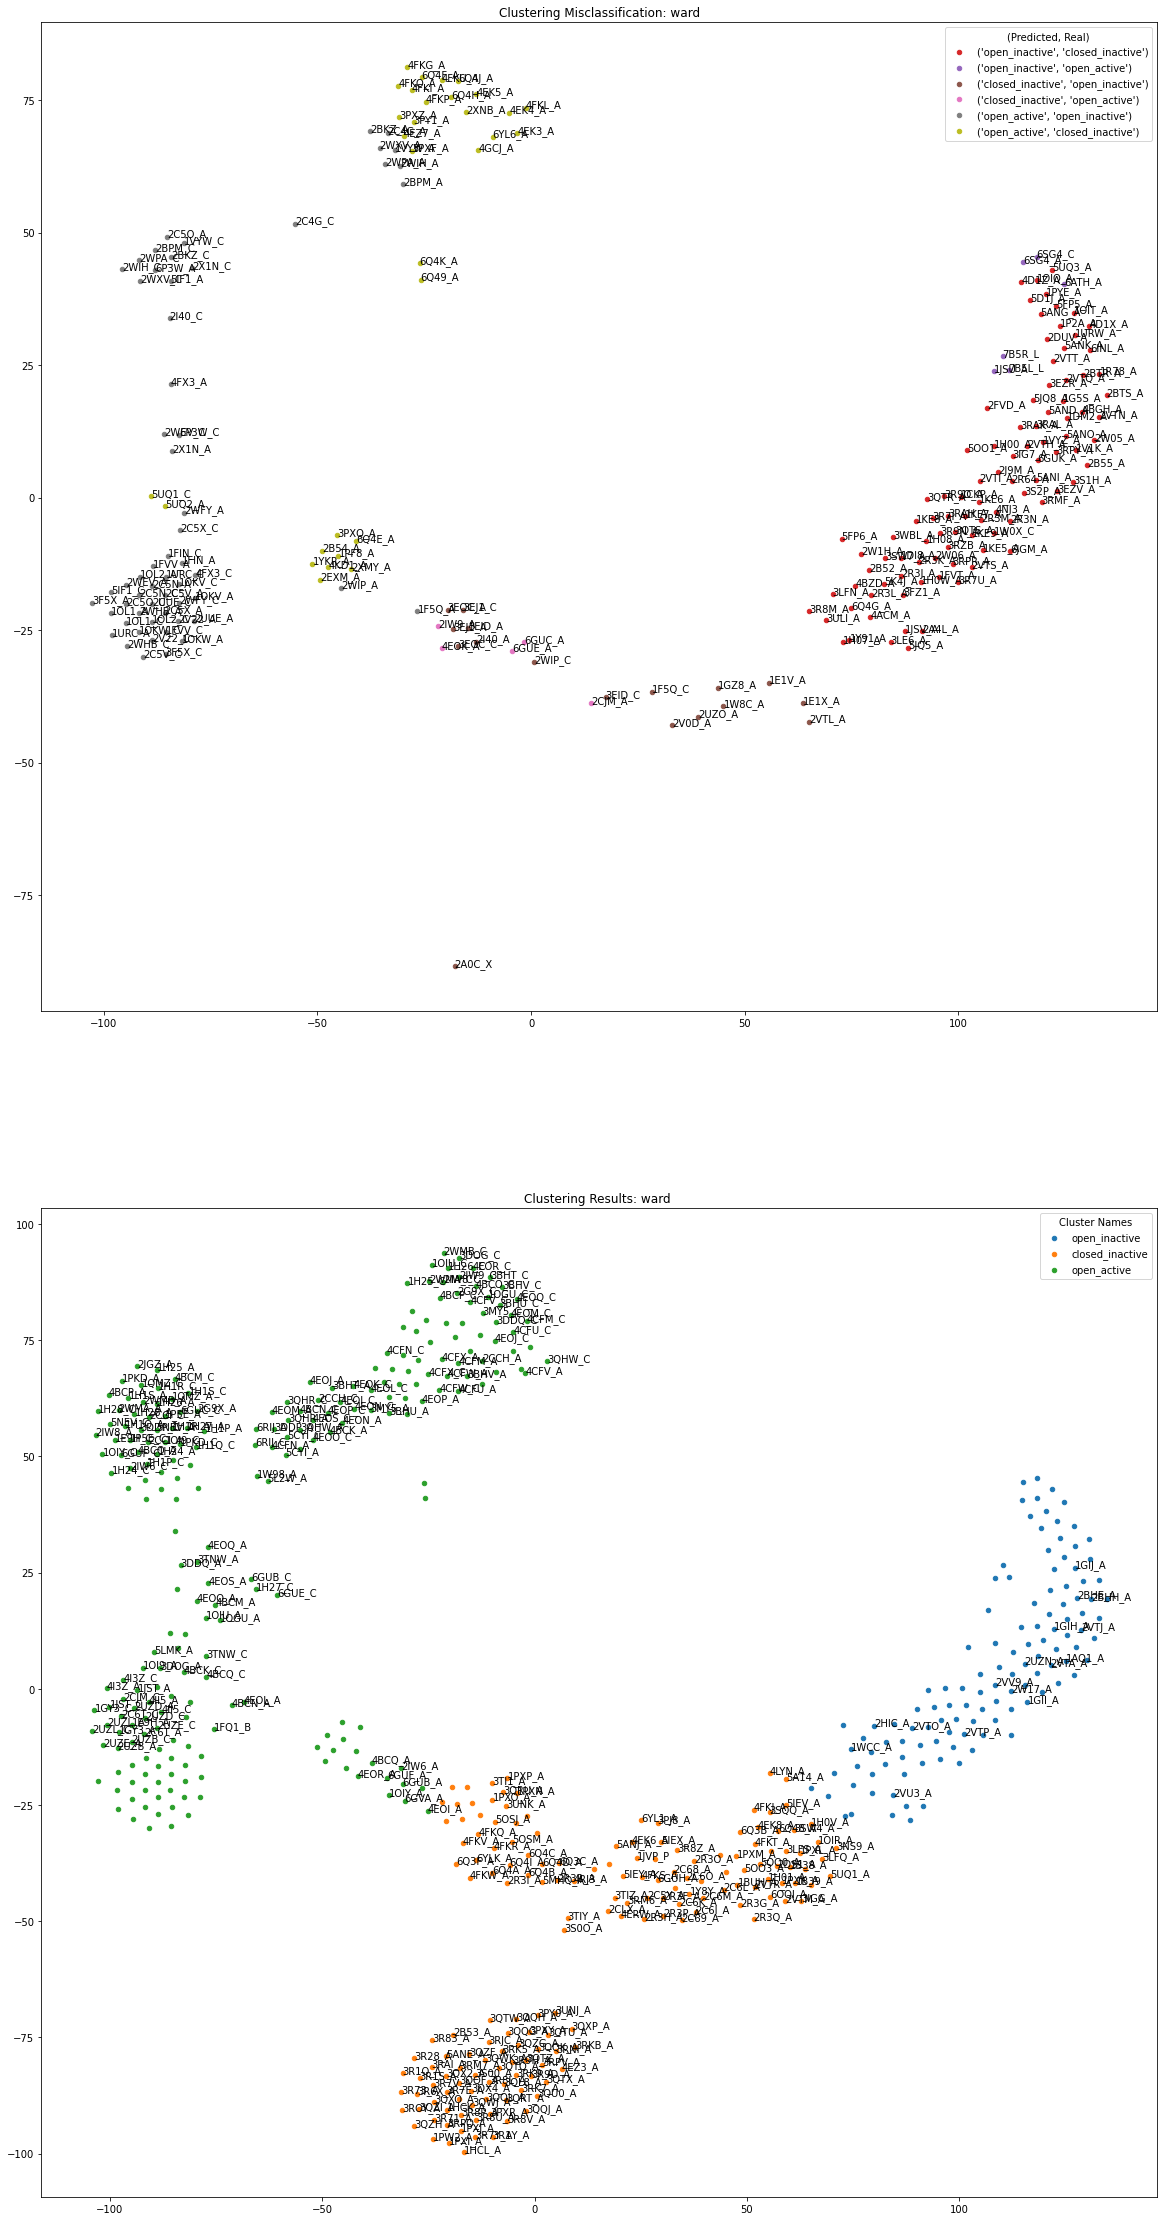

IndexError: list index out of range

In [11]:
stats_df, cc_df = info(matrix,"Complete RMSD, CA", chains_list,annotated_dict_list, kernel="linear",hierarchy_method = "ward", no_clusters=3,tsne=True)

In [ ]:
ex1_latex = stats_df.to_latex()
print(f"ex1:\n {ex1_latex}")
ex1_cc_latex = cc_df.to_latex()
print(f"ex1 cc:\n {ex1_cc_latex}")

ex1:
 \begin{tabular}{lrrr}
\toprule
{} &  Precision &    Recall &  F1 score \\
\midrule
open\_active     &   0.432432 &  0.761905 &  0.551724 \\
open\_inactive   &   0.583333 &  0.304348 &  0.400000 \\
closed\_inactive &   0.333333 &  0.181818 &  0.235294 \\
Averages        &   0.449700 &  0.416024 &  0.395673 \\
\bottomrule
\end{tabular}

ex1 cc:
 \begin{tabular}{lrrr}
\toprule
{} &  Real open\_active &  Real open\_inactive &  Real closed\_inactive \\
\midrule
Predicted open\_active     &                16 &                  16 &                     5 \\
Predicted open\_inactive   &                 1 &                   7 &                     4 \\
Predicted closed\_inactive &                 4 &                   0 &                     2 \\
\bottomrule
\end{tabular}



## Experiment 2
Complete RMSD CA and CB. Results are worse.


In [ ]:
stats_df2,cc_df2 = info(matrix_AB,"Complete RMSD CA and CB", chains_list, annotated_dict_list,kernel="linear",hierarchy_method = "ward", no_clusters=3,tsne=True)

SyntaxError: positional argument follows keyword argument (1744266201.py, line 1)

### Experiment 5
Selected Segments 33 to 44, 150 to 159, found from previous pymol modelling analysis. RSMD Matrix, T-SNE projection with Ward's algorithm to obtain 3 clusters.

### Analysis:

shape axis1: (531,) axis2: (531,)
group: open_active
group: closed_inactive
group: open_inactive


/Users/yao/Desktop/dkp/Work/internship1_bioinfo/helper.py:564: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = linkage(matrix, method = hierarchy_method, metric = dist_metric)


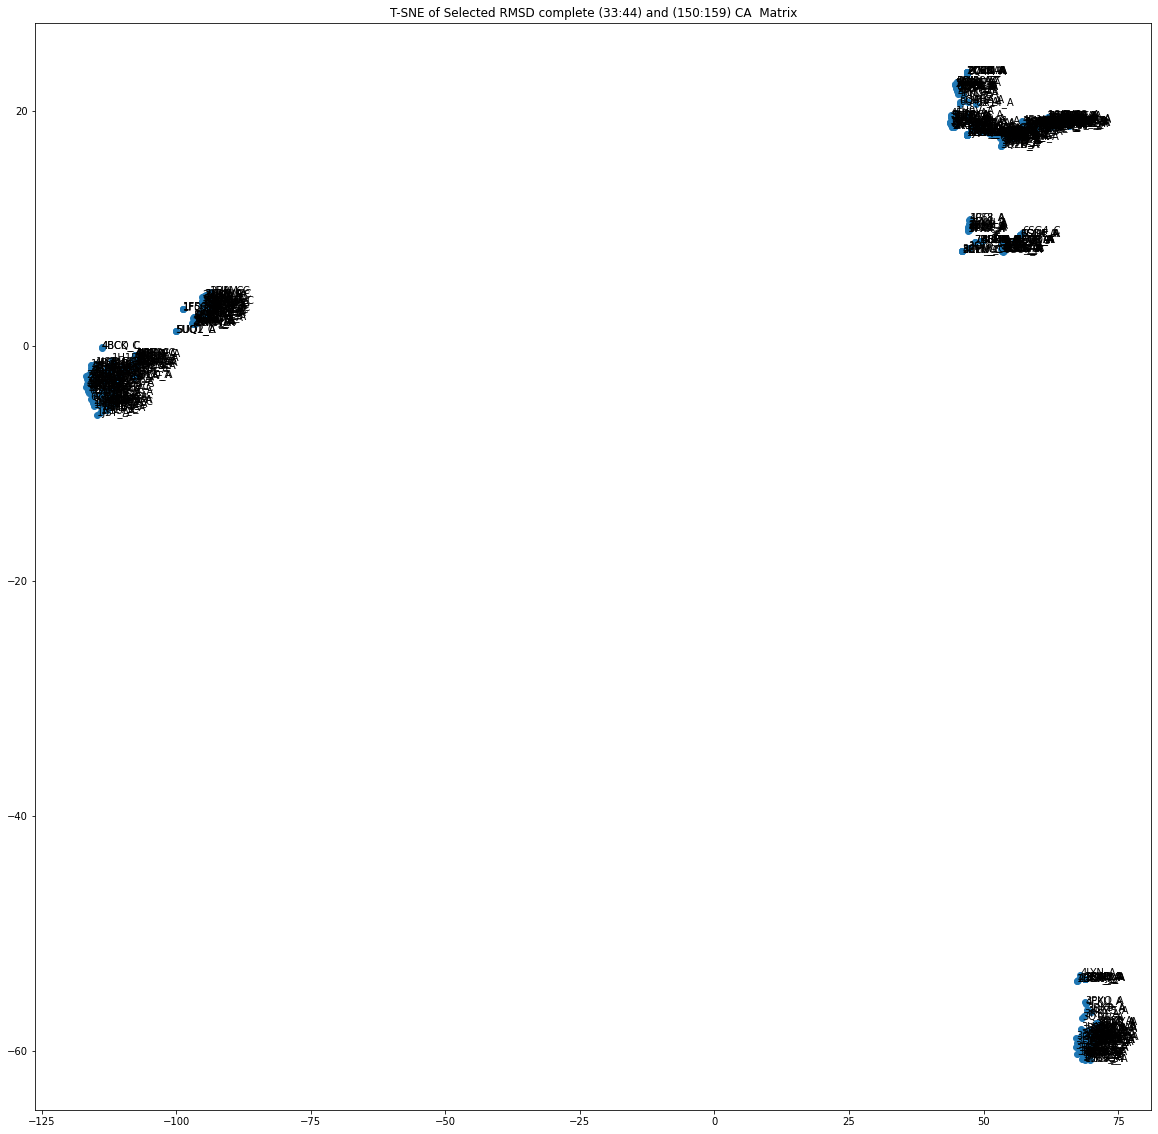

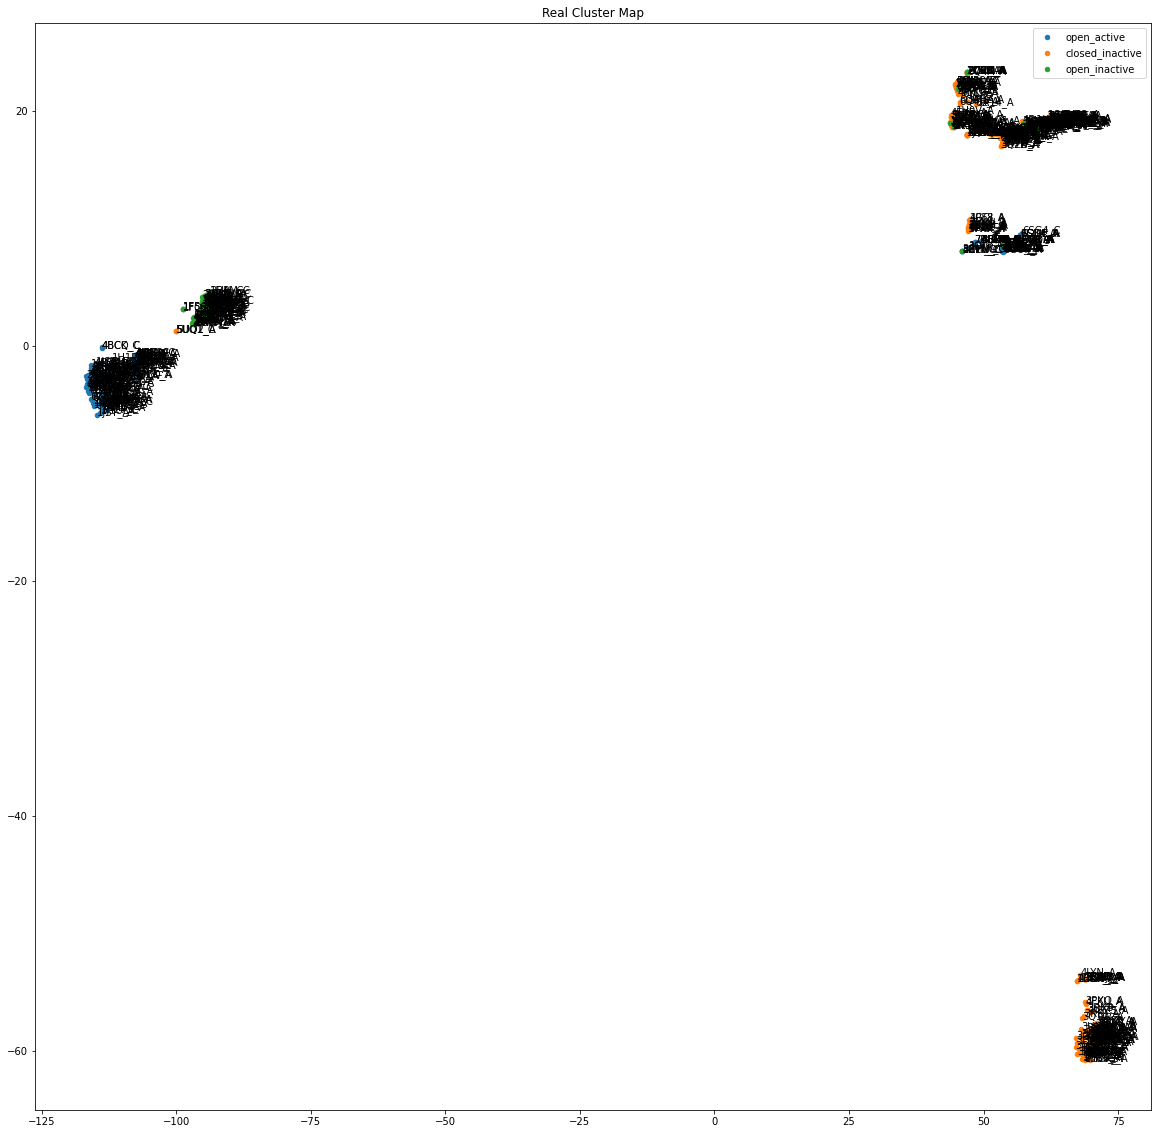

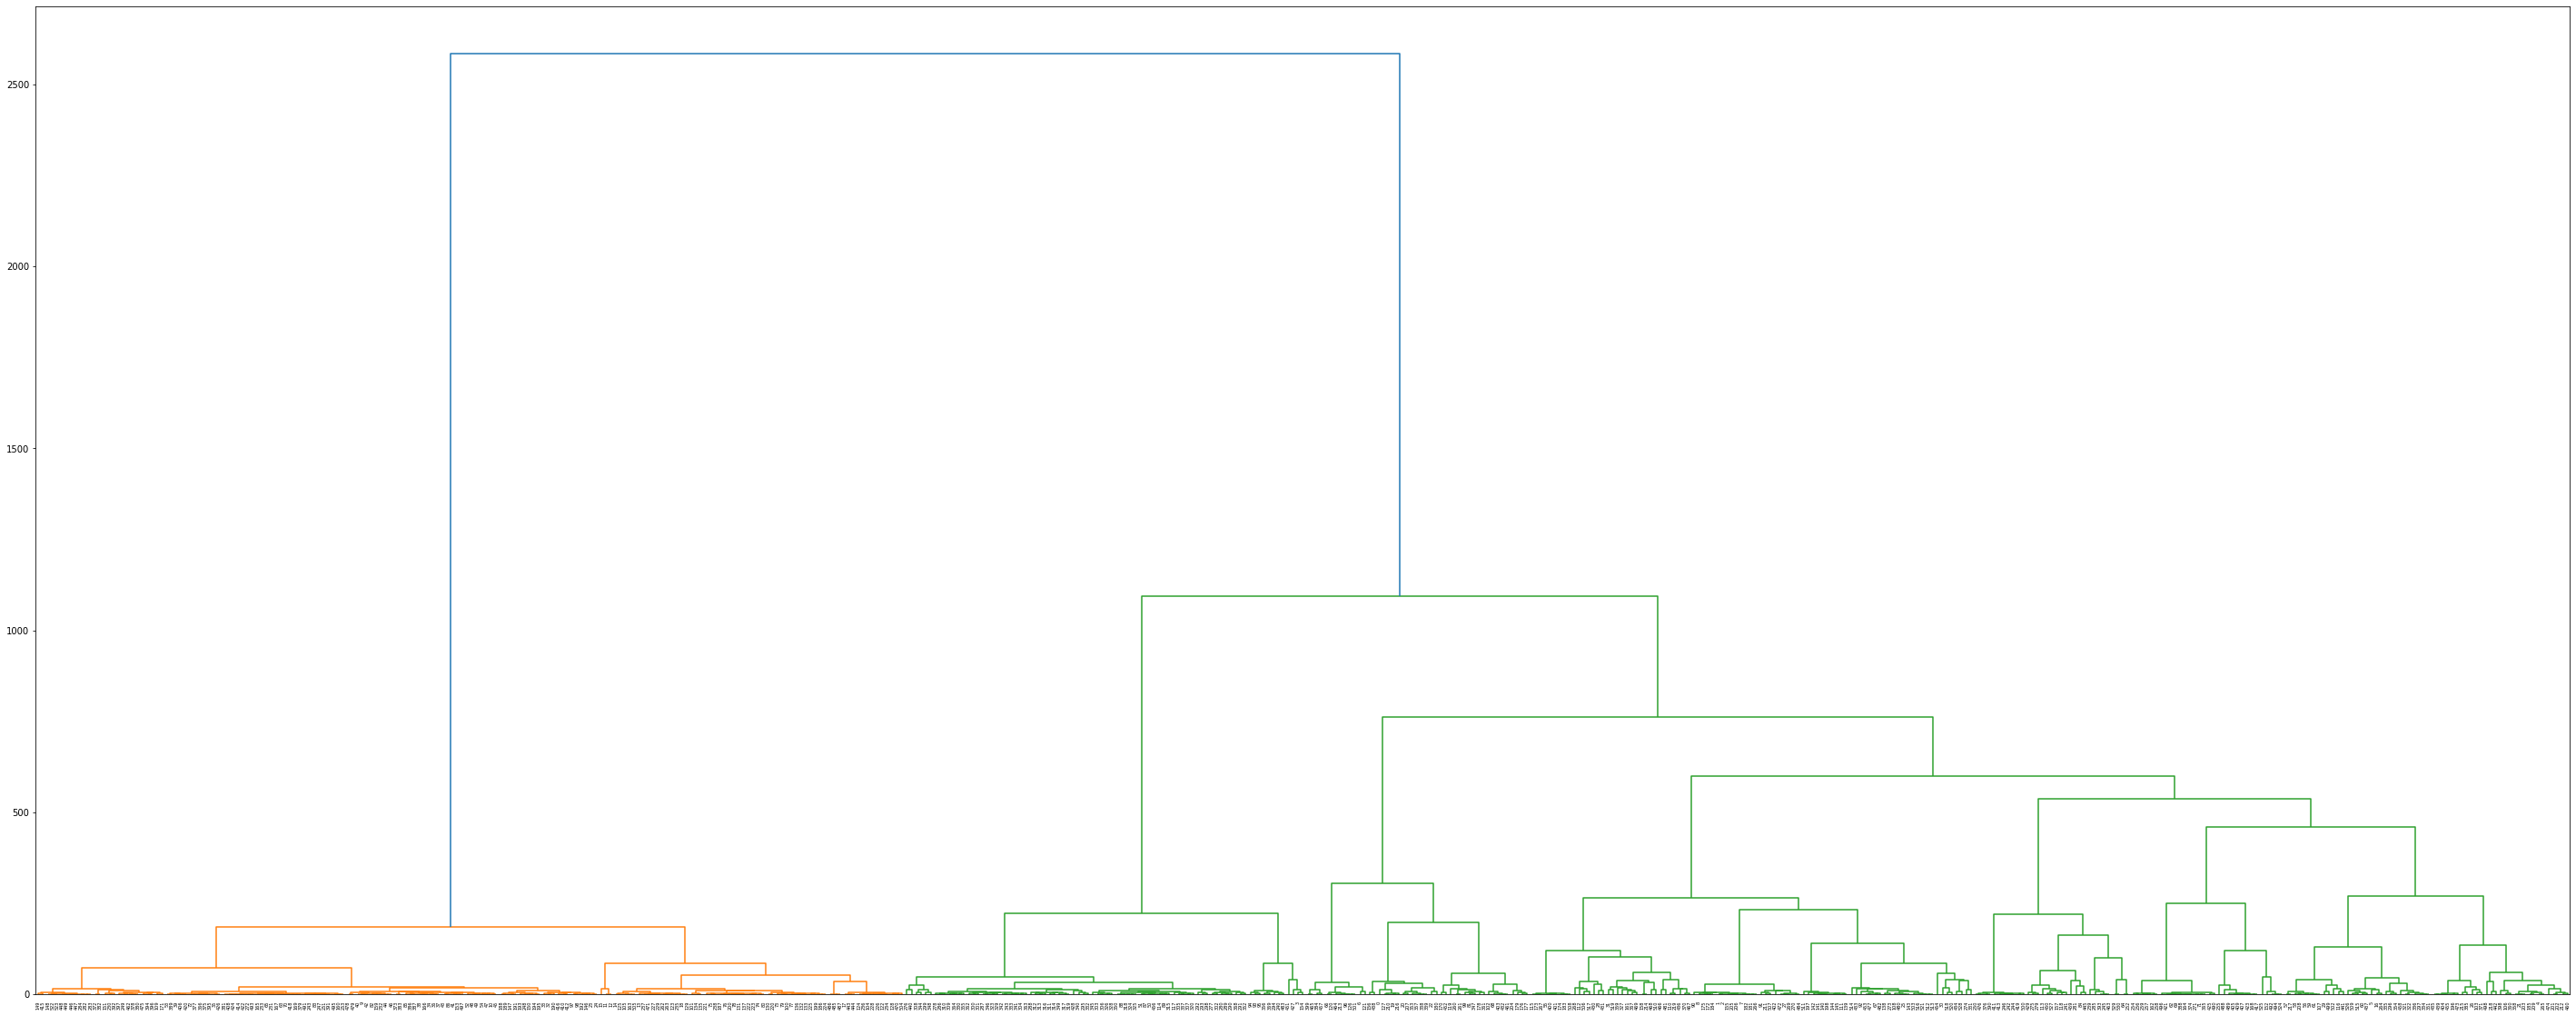

Dendrogram plotted
------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 265
cluster 1, length: 84
cluster 2, length: 182
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
closed_inactive   0.720755  0.689531  0.704797
open_inactive     0.011905  0.010870  0.011364
open_active       0.653846  0.734568  0.691860
Averages          0.462169  0.478323  0.469340
out:
                            Real closed_inactive  Real open_inactive  Real open_active
Predicted closed_inactive                   191                  31                43
Predicted open_inactive                      83                   1                 0
Predicted open_active                         3                  60               119
----------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


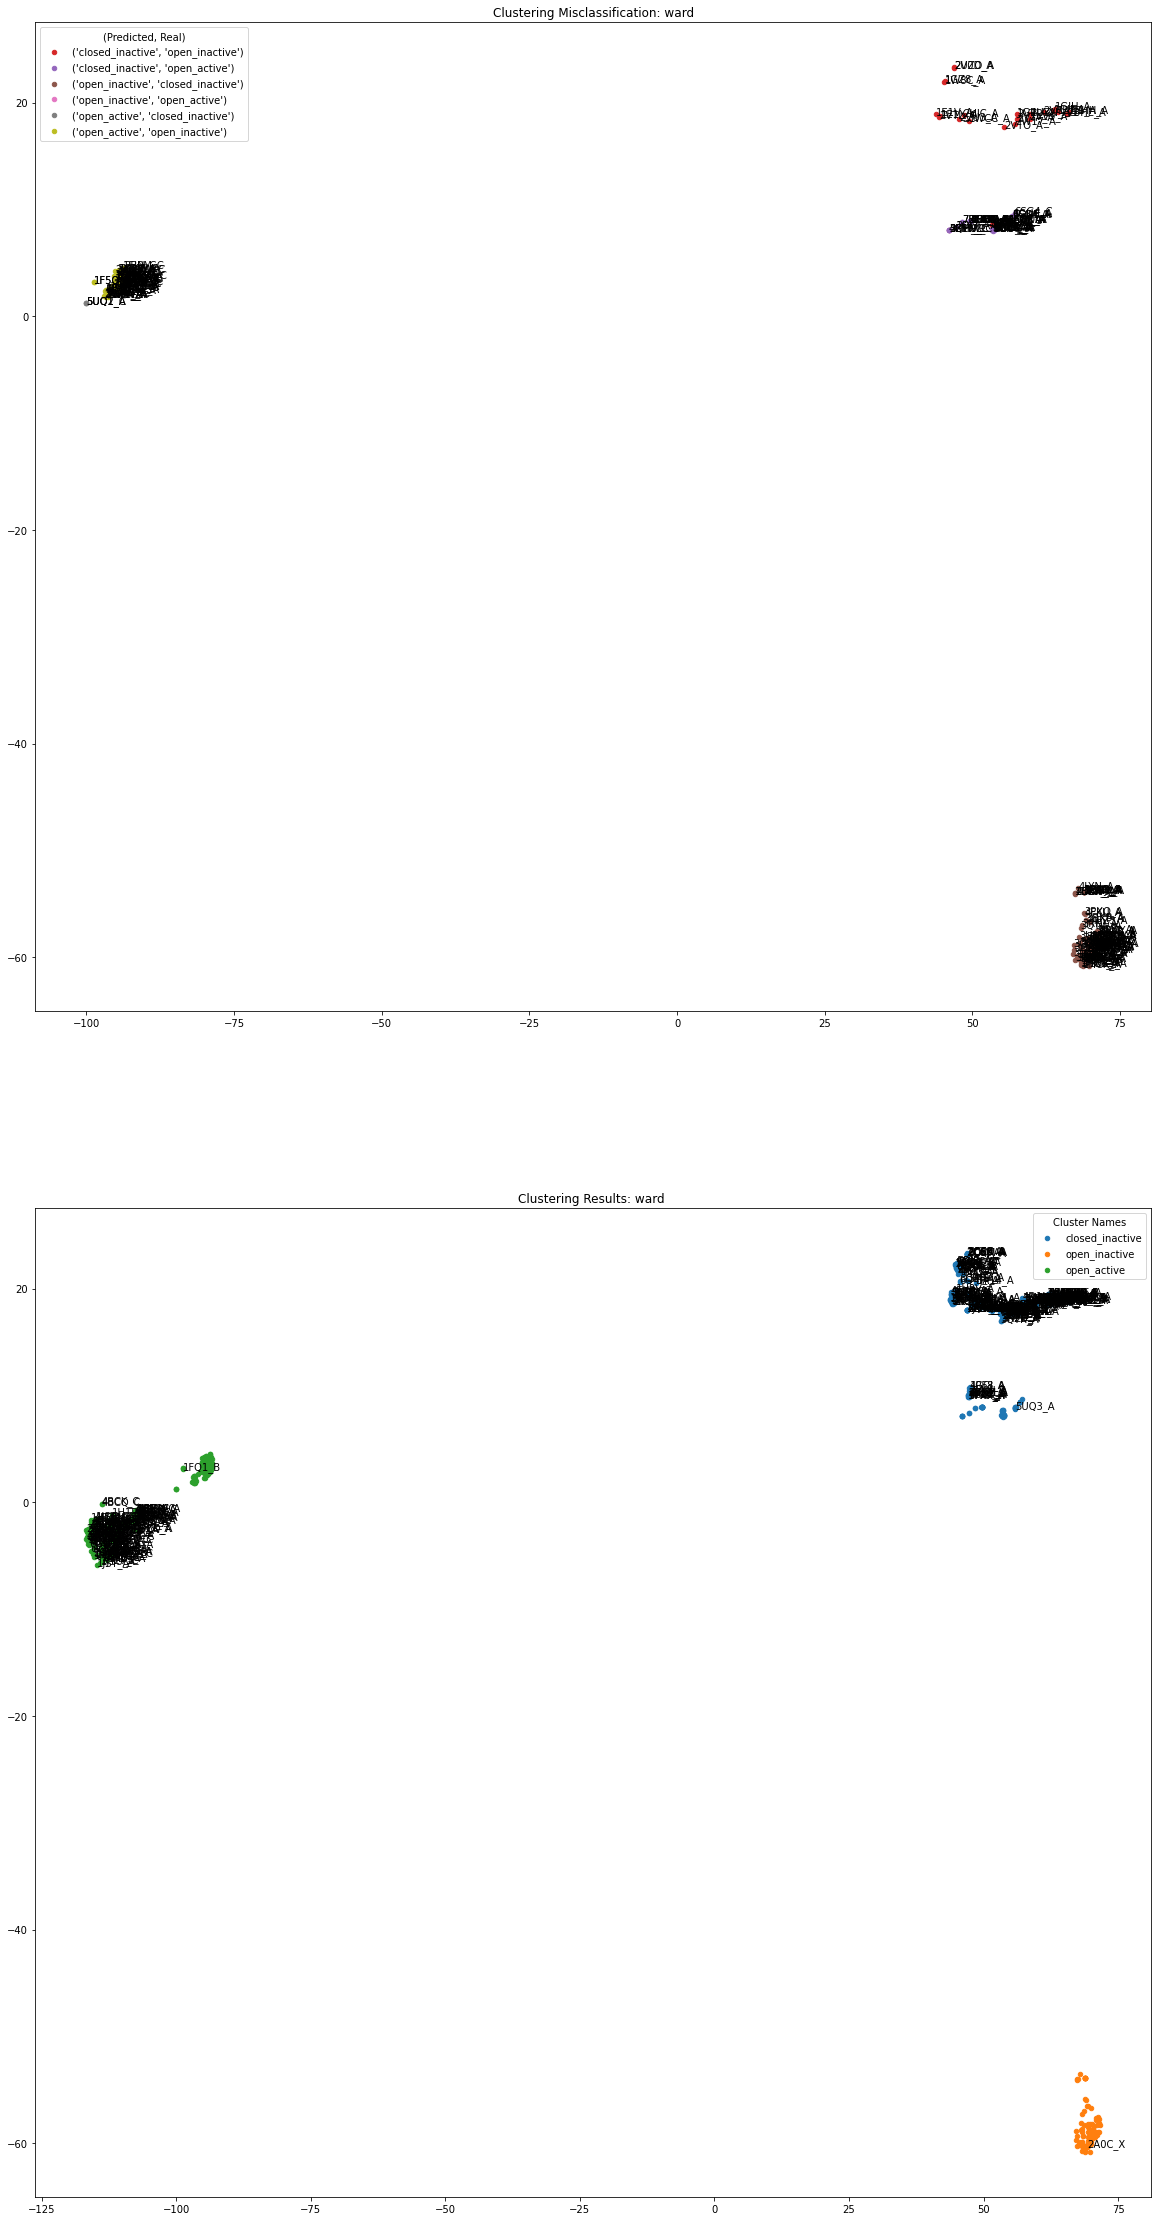

(#missing residues, percentage) [(0, 0.41818181818181815), (1, 0.3870967741935484), (2, 0.8125), (3, 0.8333333333333334), (4, 0.9523809523809523), (5, 0.8), (6, 0.36363636363636365), (7, 0.2222222222222222), (8, 0.16666666666666666), (9, 0.1875), (10, 0.2), (11, 0.1111111111111111), (12, 0.0), (13, 0.25), (14, 0.3333333333333333), (15, 0.18181818181818182), (16, 0.05263157894736842), (17, 0.14285714285714285), (18, 0.0), (19, 0.2), (20, 0.2), (21, 0.1), (22, 0.2857142857142857), (23, 0.0), (24, 0.2), (25, 0.14285714285714285), (26, 0.0), (27, 0.125), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.3333333333333333), (34, 0.0), (35, 1.0), (36, 1.0), (39, 0.0)]
miclassified_missing (list where value at i is amount of misclassified and i is amount of missing residues:
 [23, 36, 13, 15, 80, 12, 4, 4, 4, 3, 2, 1, 0, 1, 2, 2, 1, 1, 0, 3, 3, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]
totals_missing (list where value at i is number of conformations and i is amount o

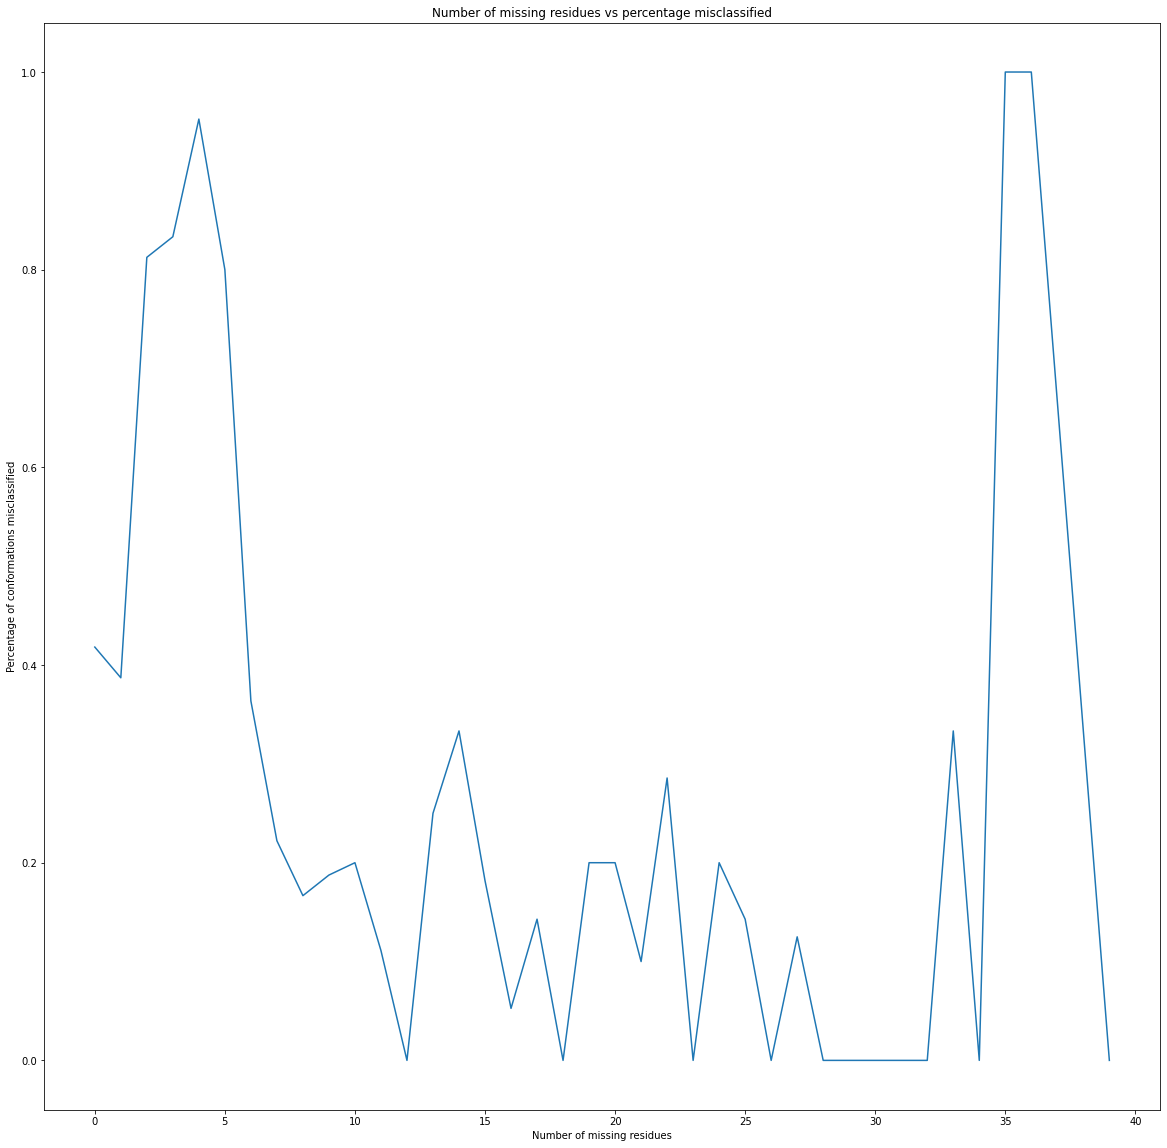

In [ ]:
stats_df3,cc_df3 =info(matrix_seg,"Selected RMSD complete (33:44) and (150:159) CA ", chains_list,annotated_dict_list,kernel="linear",hierarchy_method = "ward", no_clusters=3,tsne=True)

### Experiment 6 less intuitive partition
Selected Segments 33 to 44, 150 to 159, found from previous pymol modelling analysis. T-SNE projection with Ward's algorithm to obtain 3 clusters, Manual Tree parititioning, Cluster1 = Tree.left.left, Cluster2 = Tree.left.right, Cluster3 = Tree.right
### Analysis:
This gives quite a high F1 score, however the partitioning is not as intuitive since Cluster 1 and Cluster 2 are highly similar and have low cophenetic distances compared to the Cluster 3. Maybe a change of distance metric might give different clustering results.

Actually, running a script to check how many chains are missing more than 7 residues in on of the segments (keeping in mind that the segments are only 12 and 10 residues long). The script outputs 176 samples. This is more than the amount misclassified at 79 conformations.

Taking from the misclassified examples 2BHH_A on the top right of the graph of the misclassified conformation has a gap from residue 36 to 43 and 148 to 162 which given only two residues of course would have trouble identifying the clustering.
1AQ1_A missing from 36 to 44 and 148 to 160.

On the other side of the misclassified cluster, 2AOC_X has only missing 37-40, 4 key residues missing

shape axis1: (531,) axis2: (531,)
group: open_active
group: closed_inactive
group: open_inactive


/Users/yao/Desktop/dkp/Work/internship1_bioinfo/helper.py:564: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = linkage(matrix, method = hierarchy_method, metric = dist_metric)


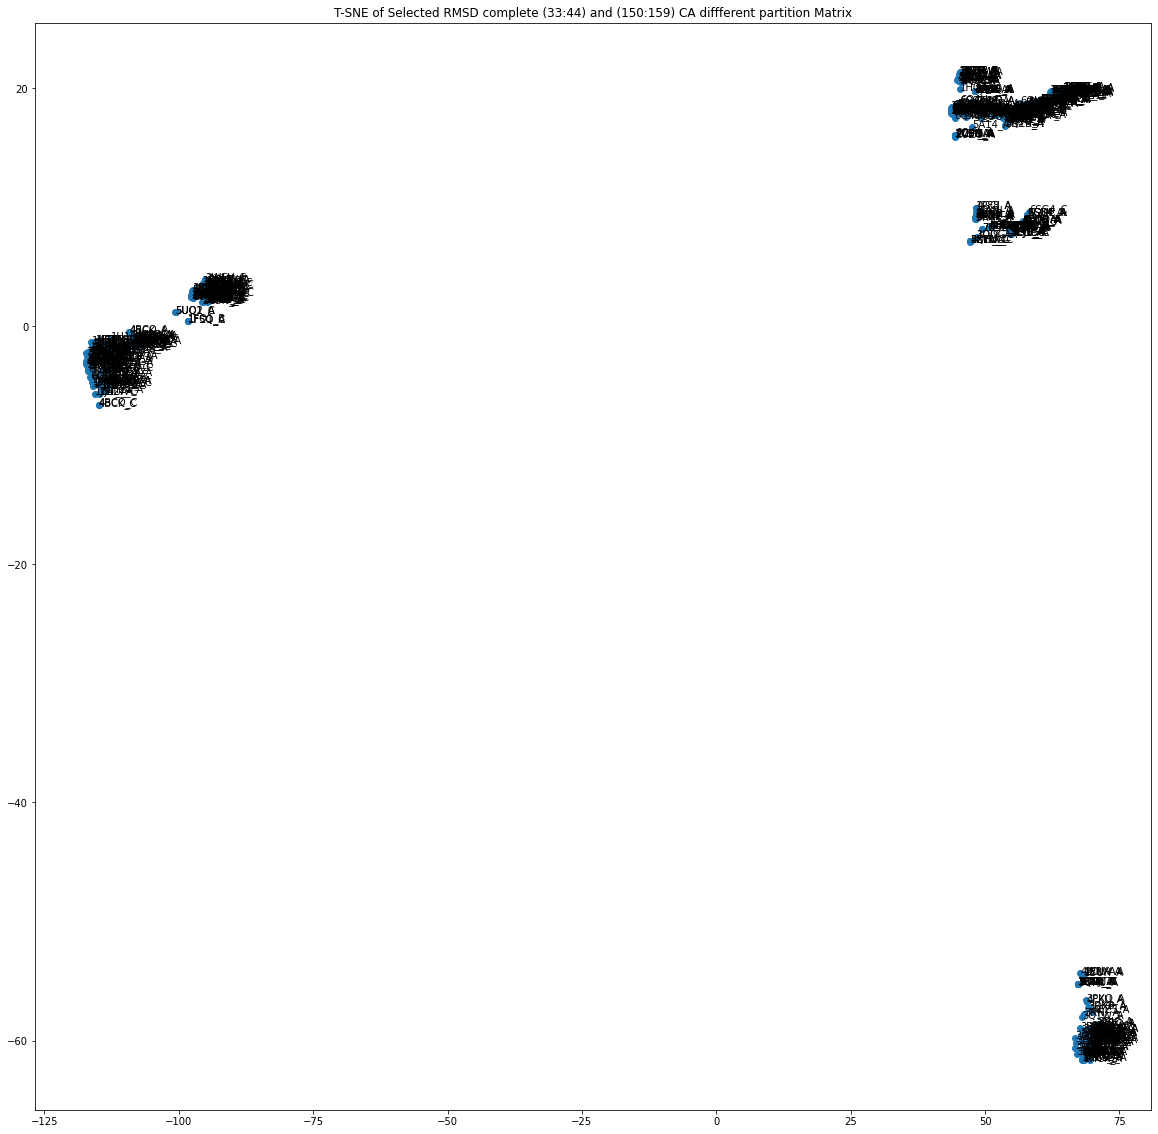

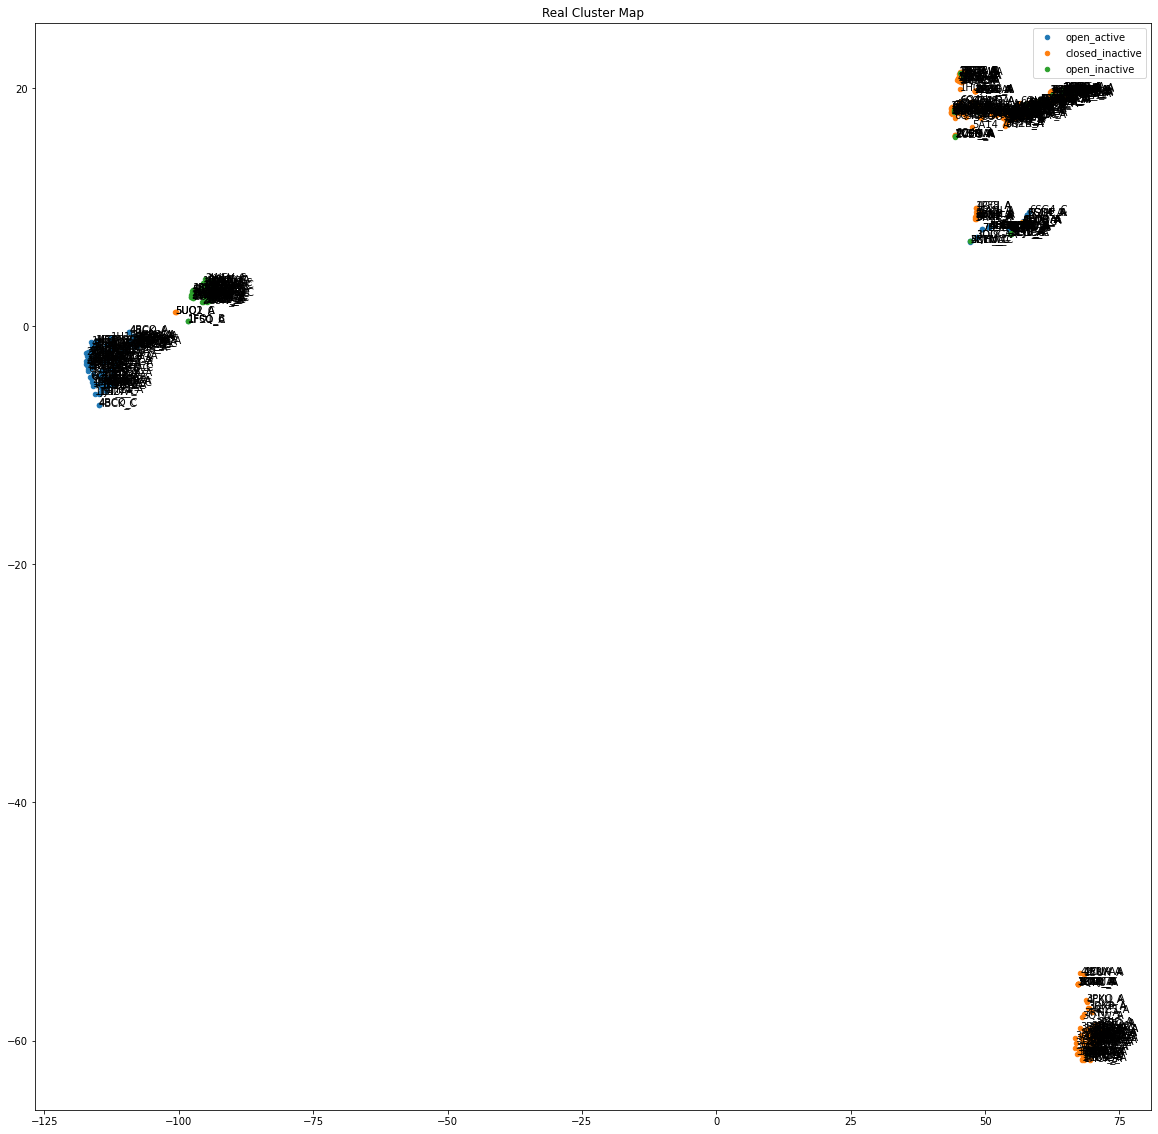

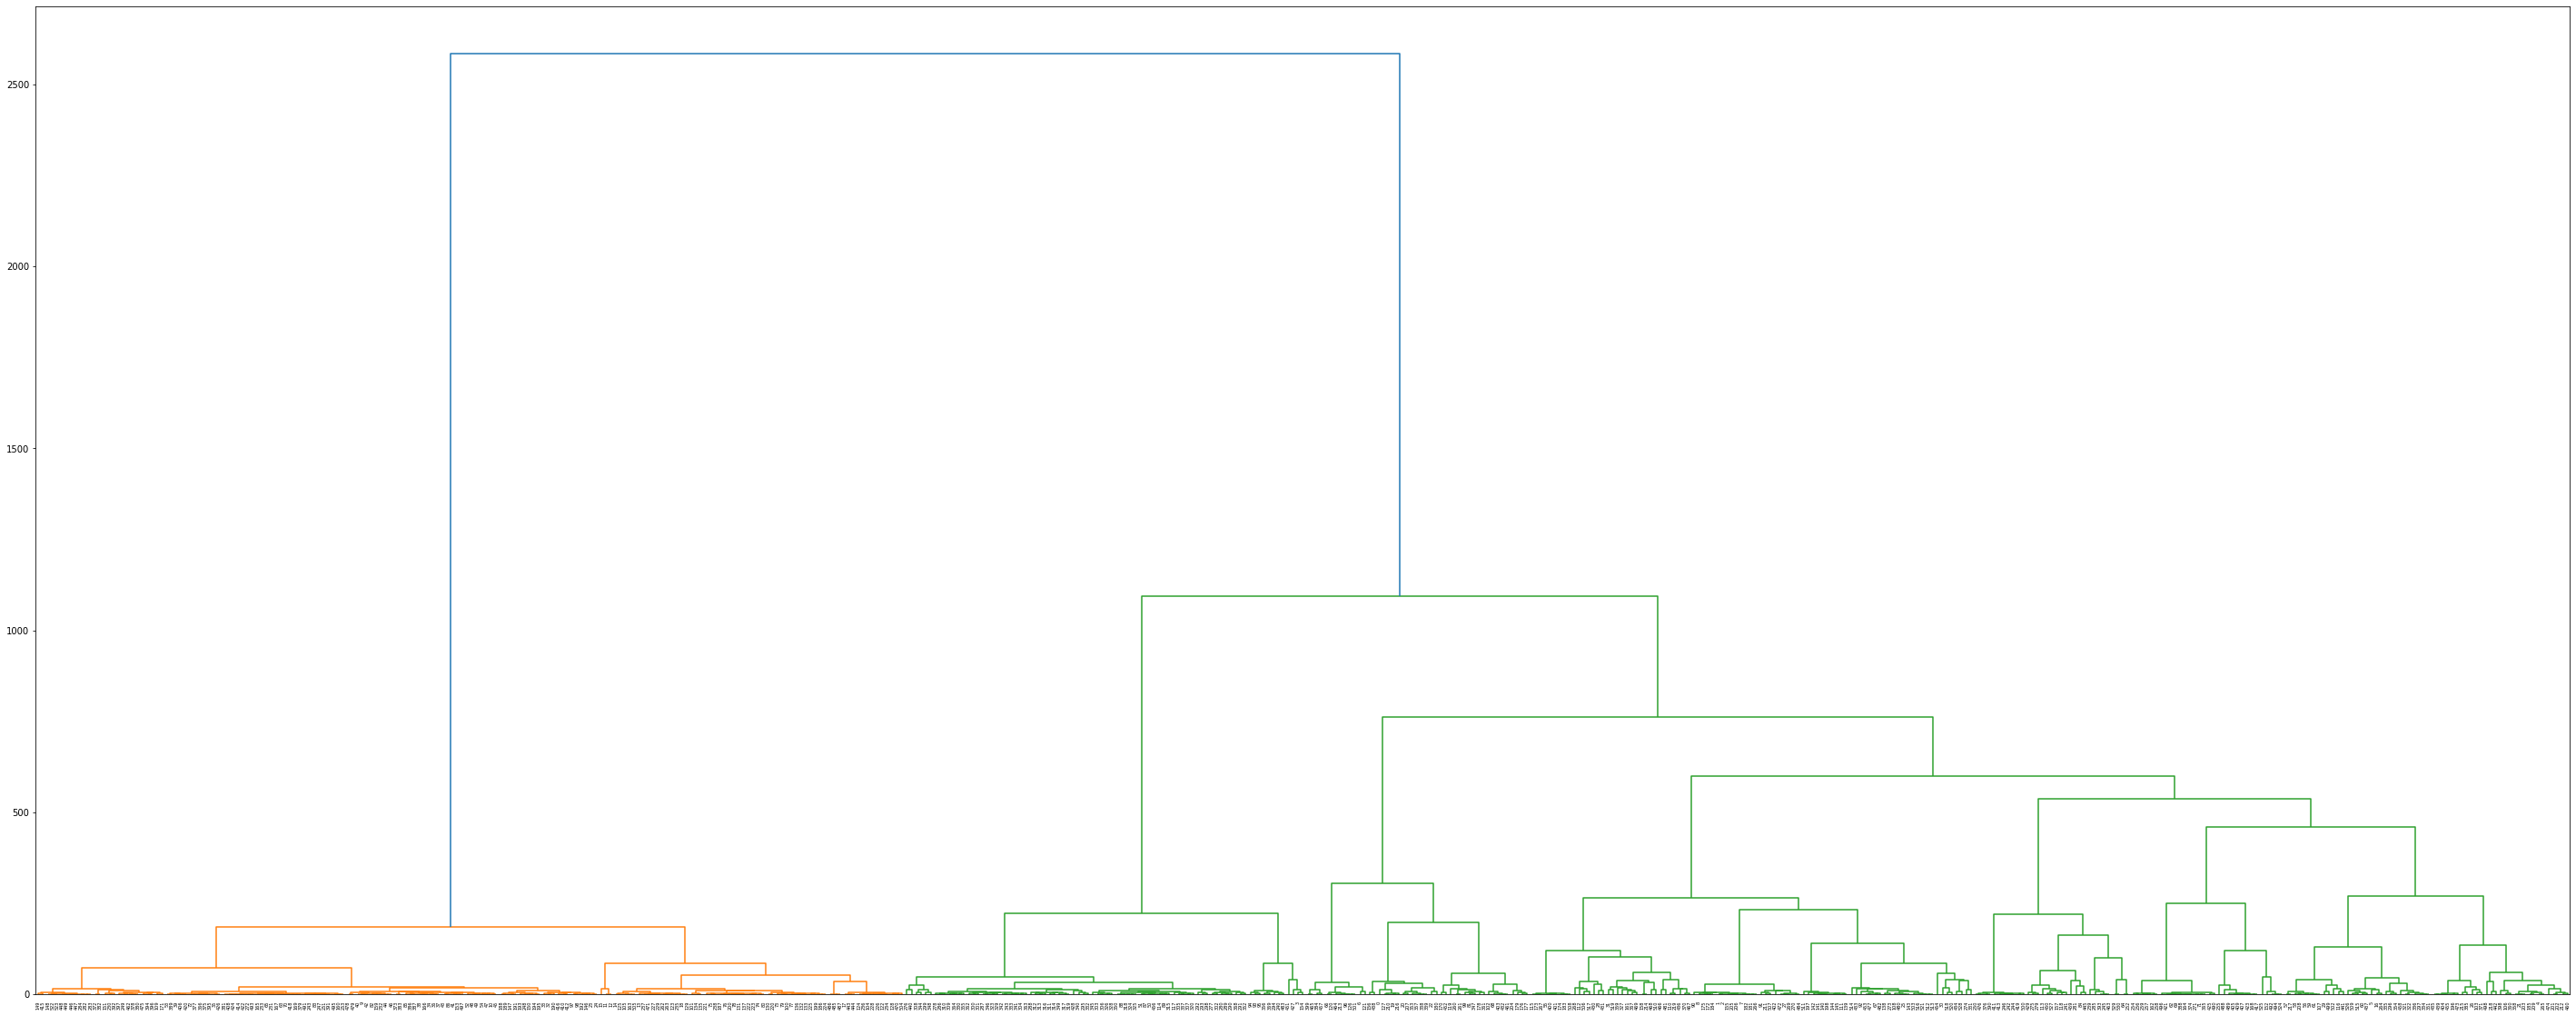

Dendrogram plotted
tree: Left Most Tree
tree: Middle Tree
Make sure the tree is just right of the previous tree or else the statistics will be inaccurate
tree1: ['l', 'l'], tree2: ['l', 'r']
------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 118
cluster 1, length: 64
cluster 2, length: 349
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
open_active       1.000000  0.728395  0.842857
open_inactive     0.937500  0.652174  0.769231
closed_inactive   0.785100  0.989170  0.875399
Averages          0.907533  0.789913  0.829162
out:
                            Real open_active  Real open_inactive  Real closed_inactive
Predicted open_active                   118                   0                     0
Predicted open_inactive                   1               

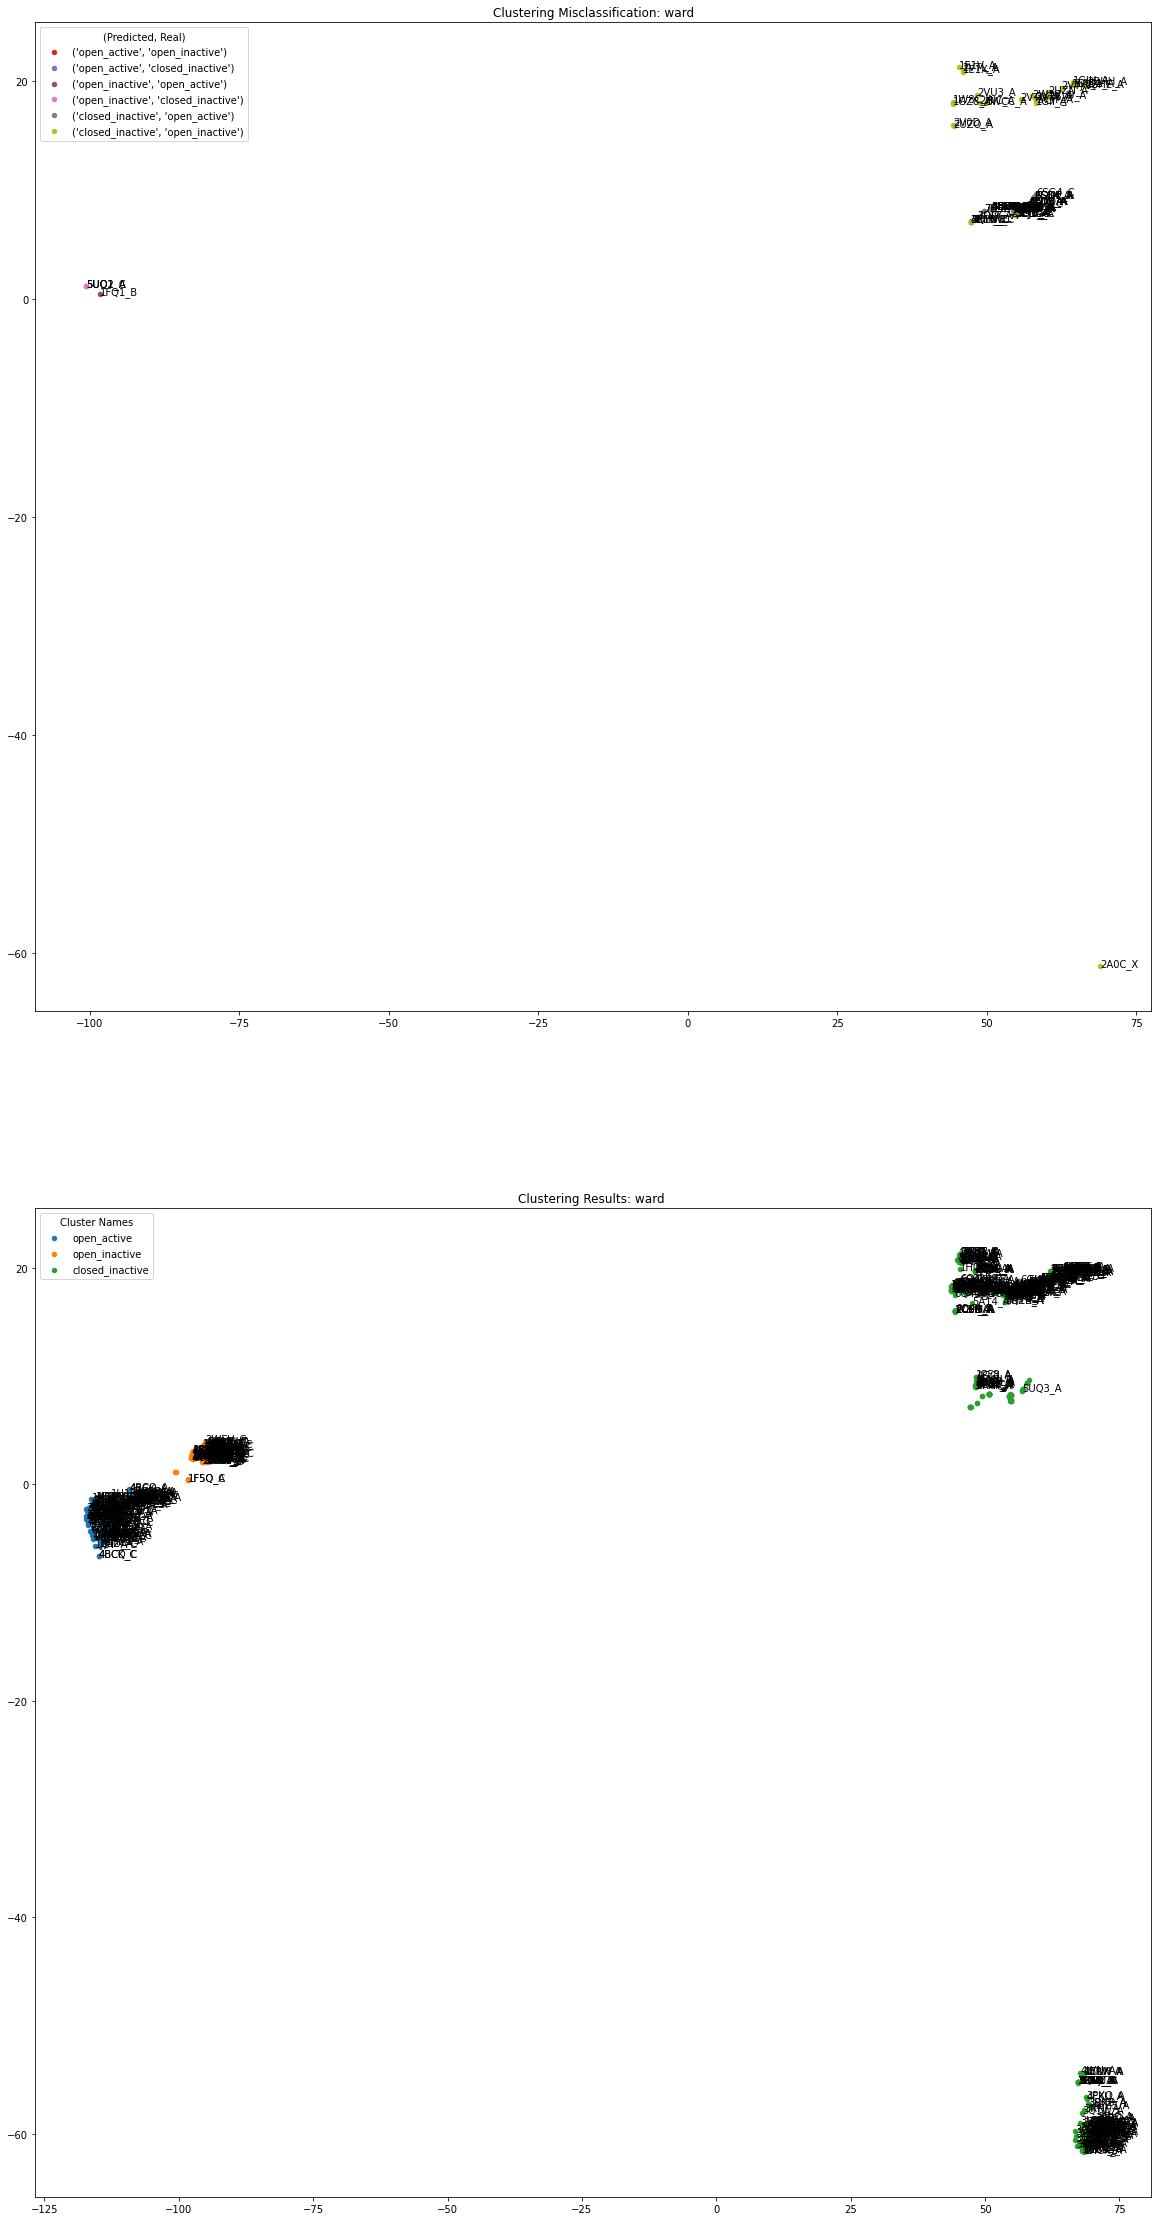

(#missing residues, percentage) [(0, 0.0), (1, 0.06451612903225806), (2, 0.625), (3, 0.6666666666666666), (4, 0.13095238095238096), (5, 0.2), (6, 0.2727272727272727), (7, 0.2222222222222222), (8, 0.16666666666666666), (9, 0.125), (10, 0.1), (11, 0.0), (12, 0.0), (13, 0.25), (14, 0.3333333333333333), (15, 0.18181818181818182), (16, 0.05263157894736842), (17, 0.14285714285714285), (18, 0.0), (19, 0.2), (20, 0.2), (21, 0.1), (22, 0.2857142857142857), (23, 0.0), (24, 0.2), (25, 0.14285714285714285), (26, 0.0), (27, 0.125), (28, 0.0), (29, 0.0), (30, 0.0), (31, 0.0), (32, 0.0), (33, 0.3333333333333333), (34, 0.0), (35, 1.0), (36, 1.0), (39, 0.0)]
miclassified_missing (list where value at i is amount of misclassified and i is amount of missing residues:
 [0, 6, 10, 12, 11, 3, 3, 4, 4, 2, 1, 0, 0, 1, 2, 2, 1, 1, 0, 3, 3, 1, 2, 0, 2, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0]
totals_missing (list where value at i is number of conformations and i is amount of missing residues:
 [55, 93, 16, 1

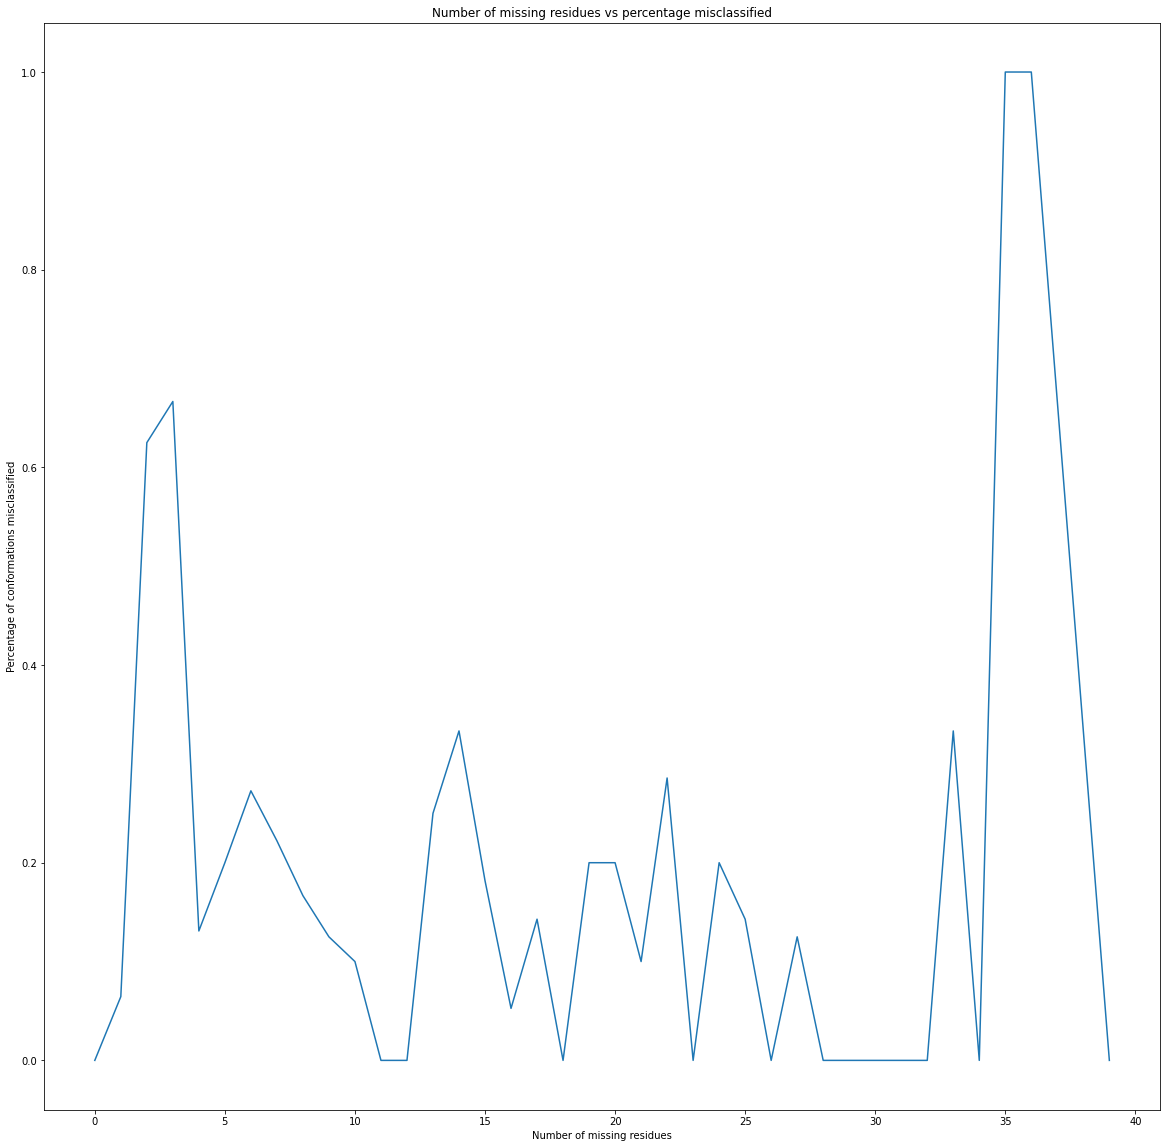

In [ ]:
stats_df4,cc_df4 = info(matrix_seg,"Selected RMSD complete (33:44) and (150:159) CA diffferent partition", chains_list,annotated_dict_list, hierarchy_method = "ward", no_clusters=3,tsne=True,auto_cut_tree=False)

## RMSD CA no missing residues selected segment 143 to 164:
To compare the results with PSS and Coordinate-based we study RMSD of CA without missing residues on the activation loop.
To start off we remove any conformations which have more than 1 missing residue on the activation loop

In [ ]:
threshold_remove(threshold=1, segments=[(143,164)])

Threshold: 1 amount removed: 146


([[[array([[  9.932581, -22.664152, -16.196915]], dtype=float32),
    array([[  8.915028, -19.30223 , -14.556105]], dtype=float32),
    array([[ 11.313942, -19.738045, -11.689028]], dtype=float32),
    array([[ 11.15982 , -16.616524,  -9.48522 ]], dtype=float32),
    array([[  8.208521, -14.887178, -11.17189 ]], dtype=float32),
    array([[  5.6975822, -15.369288 ,  -8.266737 ]], dtype=float32),
    array([[  7.931435 , -13.416527 ,  -5.9093475]], dtype=float32),
    array([[  8.732009, -10.837408,  -8.550835]], dtype=float32),
    array([[  5.0804057, -10.104563 ,  -9.400251 ]], dtype=float32),
    array([[  2.5147917, -11.434275 ,  -6.8081384]], dtype=float32),
    array([[  0.31855488, -14.6537    ,  -7.1198273 ]], dtype=float32),
    array([[ -3.321835, -13.789785,  -7.931199]], dtype=float32),
    array([[ -6.369266, -16.008028,  -7.203903]], dtype=float32),
    array([[ -7.3140416, -15.723498 , -10.8804455]], dtype=float32),
    array([[ -5.067141, -15.57581 , -13.939293]], dtype

In [ ]:

with open("reduced_chains_list.var","rb") as reduced_chains_list_var:
   reduced_chains_list = pickle.load(reduced_chains_list_var)
   reduced_chains_list_var.close()
#print(f"chains_list: {chains_list}")
with open("structures/opened_active.var", "rb") as open_active_var:
    open_active_list = pickle.load(open_active_var)
    open_active_var.close()
with open("structures/closed_inactive.var", "rb") as closed_inactive_var:
    closed_inactive_list = pickle.load(closed_inactive_var)
    closed_inactive_var.close()
with open("structures/opened_inactive.var", "rb") as open_inactive_var:
    open_inactive_list = pickle.load(open_inactive_var)
    open_inactive_var.close()

print(f"open_active: {len(open_active_list)}")
print(f"closed_inactive: {len(closed_inactive_list)}")
print(f"open_inactive: {len(open_inactive_list)}")
annotated_dict_list_codes= {"open_active": open_active_list, "closed_inactive": closed_inactive_list, "open_inactive": open_inactive_list} #dictionary of codes list
annotated_dict_list ={"open_active": list(), "closed_inactive": list(), "open_inactive": list()} #dictionary of list of indices
for i,conformation in enumerate(reduced_chains_list):
    for j,l in enumerate(annotated_dict_list_codes):
        if conformation in annotated_dict_list_codes[l]:
            #print(f"l: {l}")
            annotated_dict_list[l].append(i)
print(f"reduced lengths")
for key in annotated_dict_list:
    print(f"{key}: {len(annotated_dict_list[key])}")
with open("matrix_144to166.var", "rb") as matrix_144to166_var:
   matrix_144to166 = (pickle.load(matrix_144to166_var))
   matrix_144to166_var.close()
print(f"shape matrix 144 to 166: {np.shape(matrix_144to166)}")

open_active: 162
closed_inactive: 277
open_inactive: 92
reduced lengths
open_active: 160
closed_inactive: 152
open_inactive: 73
shape matrix 144 to 166: (531, 531)


remaining_indices: 385
new matrix shape: (385, 385)
shape: (385, 2)
type X: <class 'numpy.ndarray'>,  type - ax1[0]: <class 'numpy.float32'> axis1.tolist()[0]: ()
group indices: [  5   6  11  14  15  18  19  20  21  22  23  24  25  26  27  28  29  30
  31  32  33  34  35  38  39  40  42  43  44  45  47  48  49  50  59  60
  62  63  73  74  80 109 110 111 112 113 114 115 116 120 121 123 124 125
 126 127 128 129 140 141 142 143 144 145 146 147 165 166 167 168 177 178
 179 180 181 182 183 184 185 186 187 188 199 200 209 210 211 212 271 272
 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292
 293 294 295 296 297 298 302 303 304 305 306 307 308 309 310 311 312 313
 314 315 316 317 318 319 320 321 322 323 333 334 335 336 340 341 345 346
 348 349 358 359 360 361 362 363 364 365 366 367 379 380 381 382]
group indices: [  0   1   2  17  36  37  41  46  61  64  65  66  67  68  69  70  71  72
  81  82  84  85  86 101 102 103 104 105 106 107 108 117 118 119 130 131
 132 133 13

/Users/yao/Desktop/dkp/Work/internship1_bioinfo/helper.py:604: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = linkage(matrix, method = hierarchy_method, metric = dist_metric)


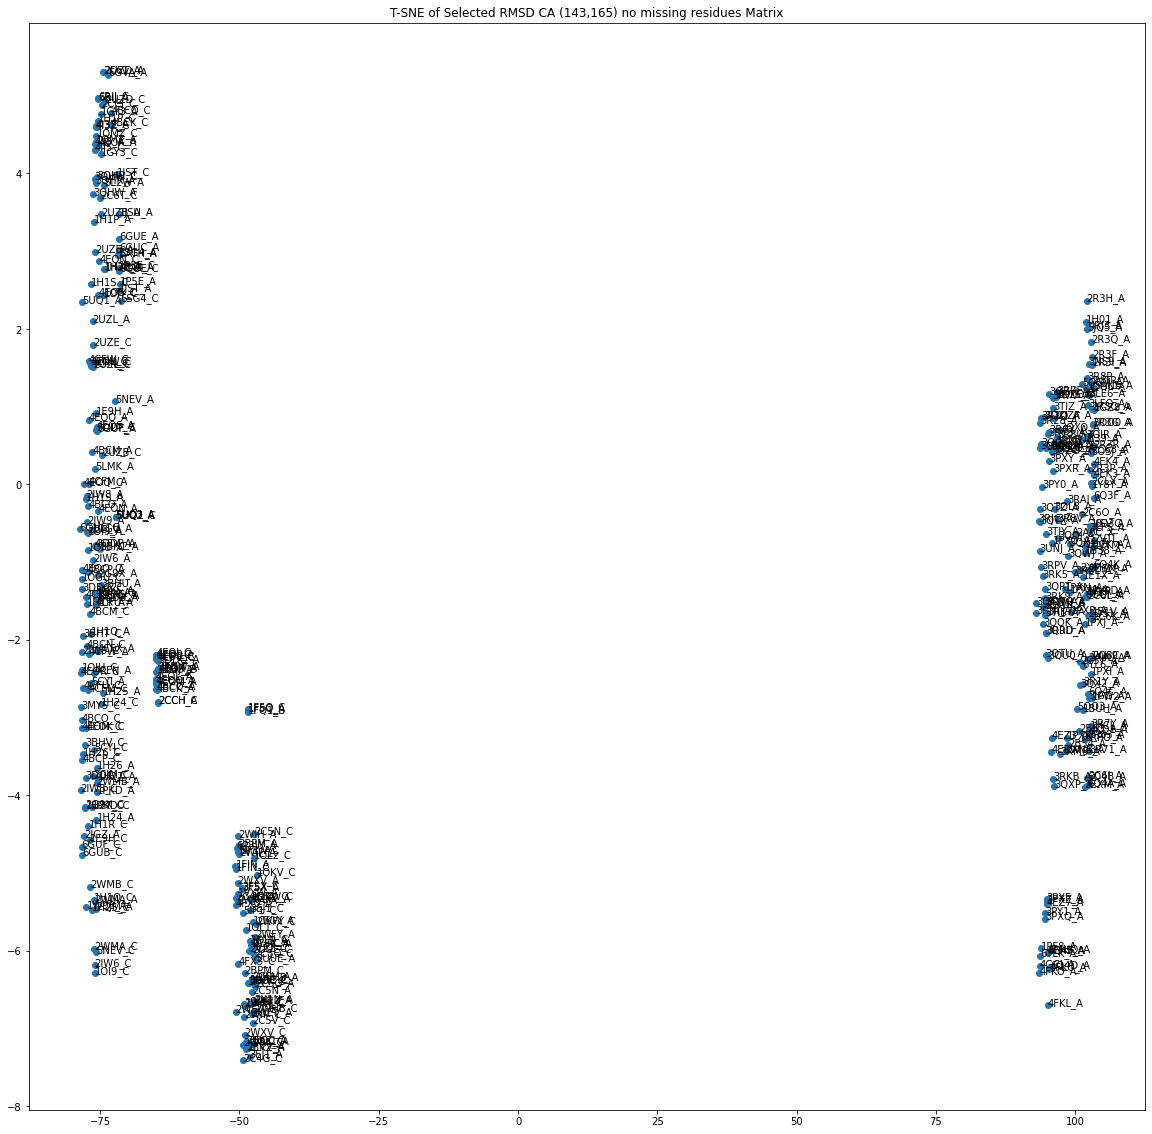

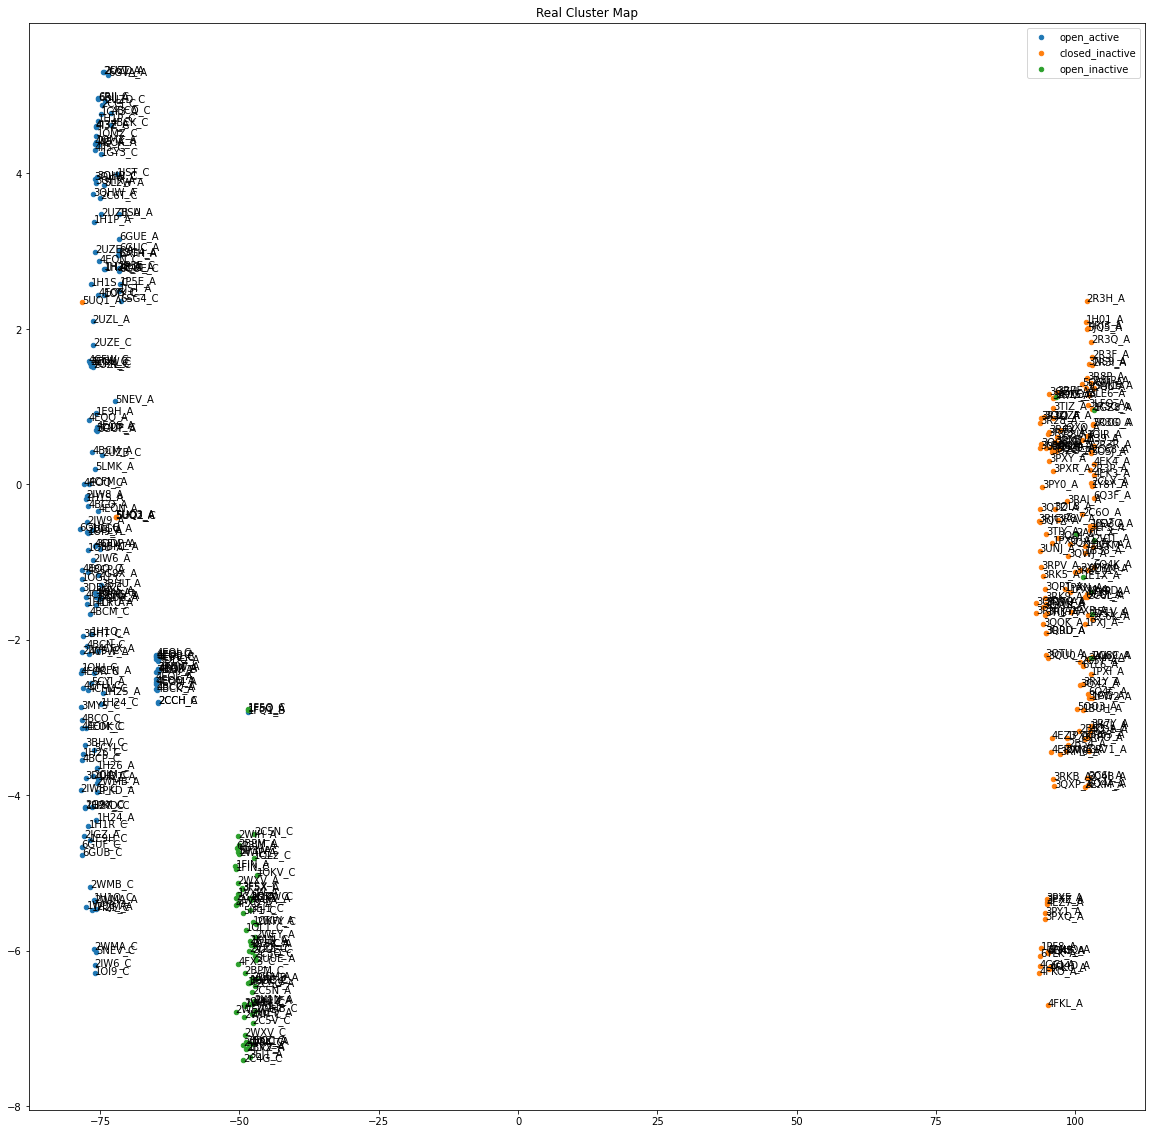

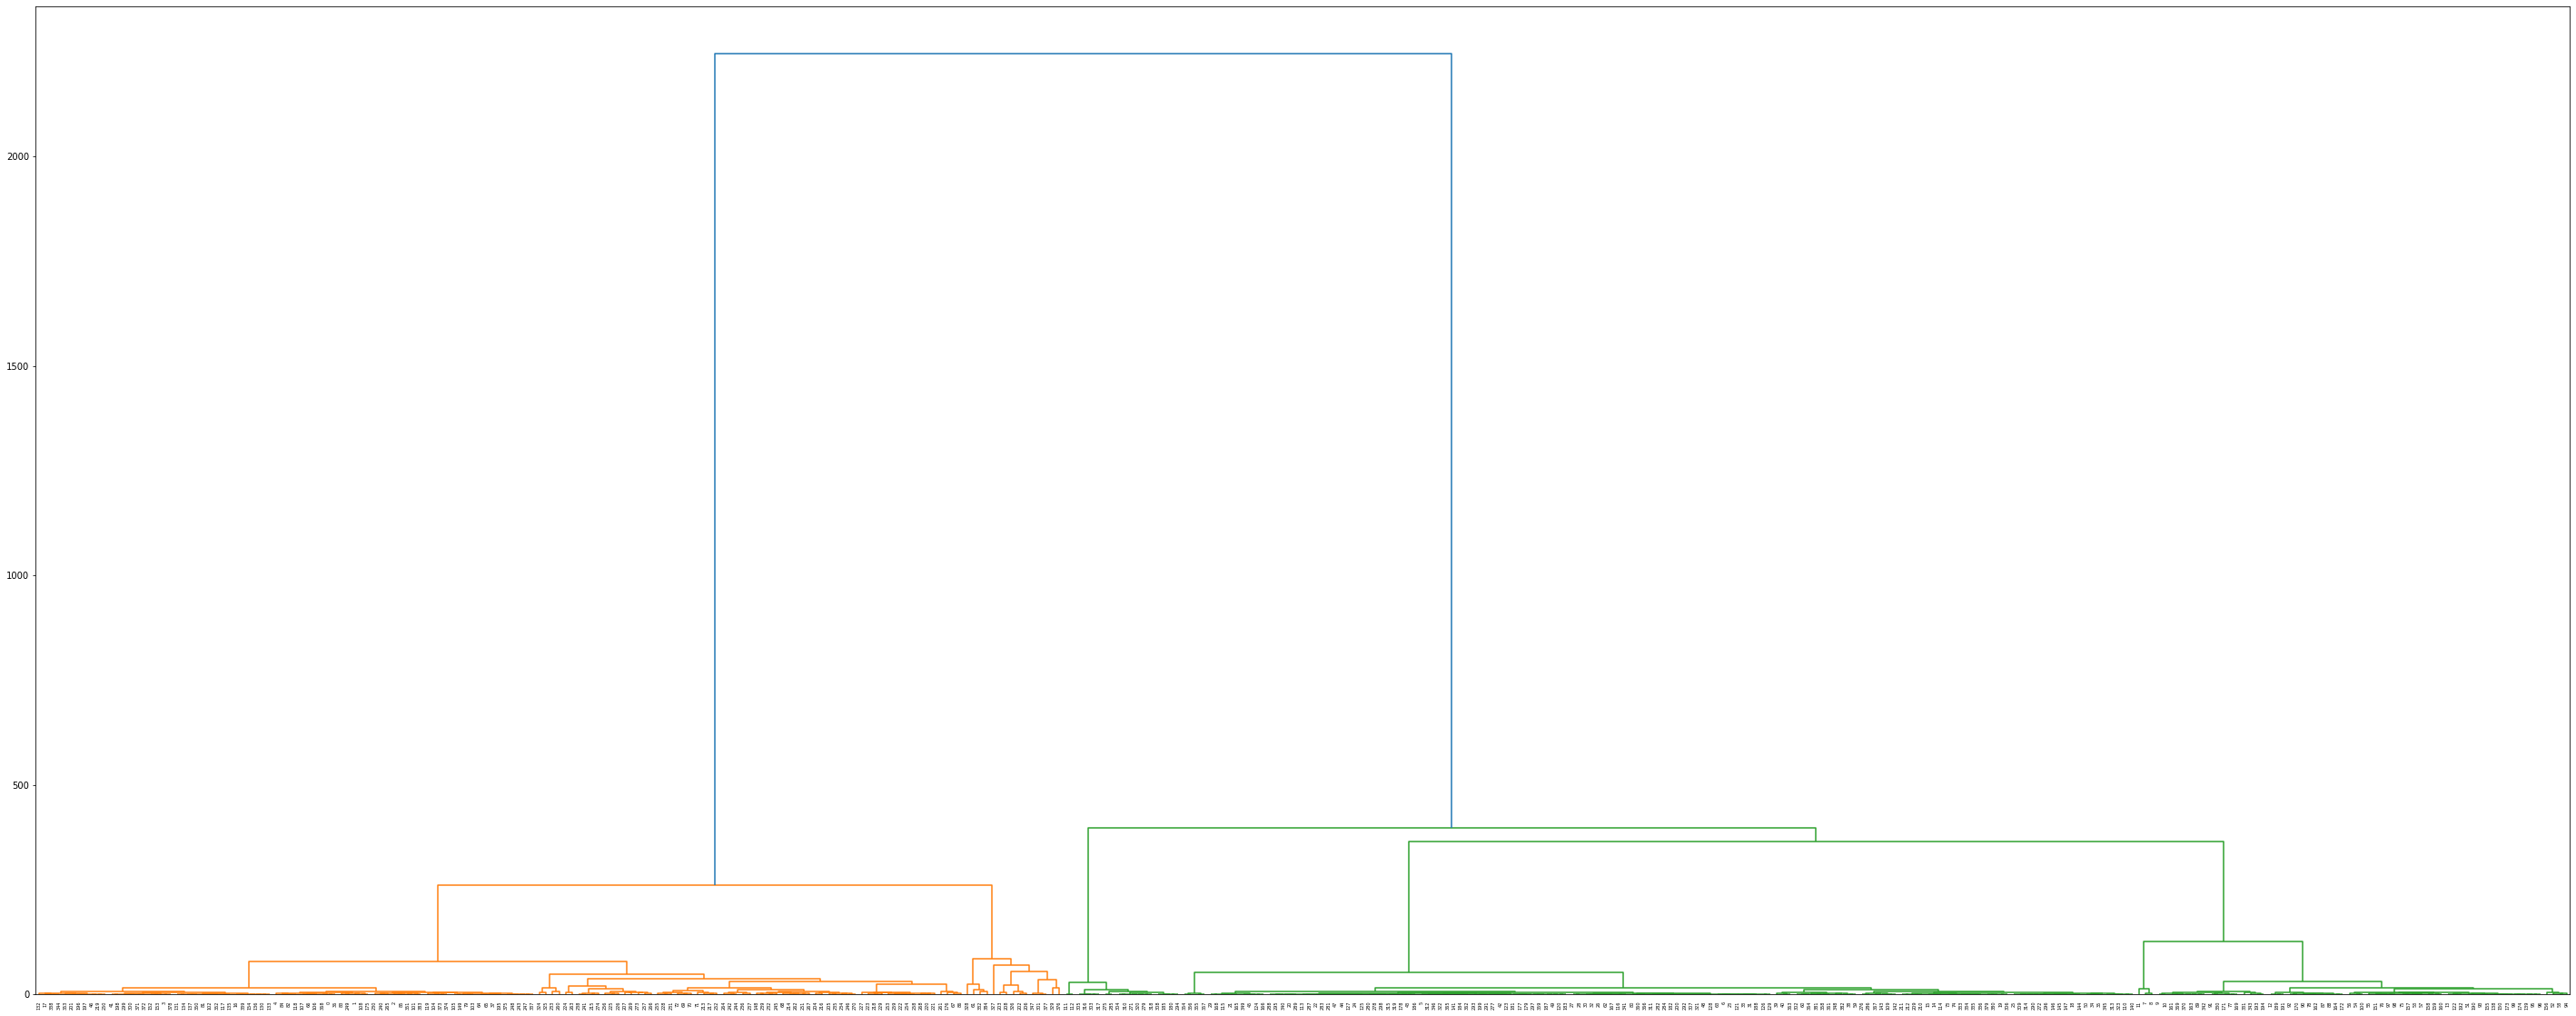

Dendrogram plotted
------------------------------------------------------------
STATISTICS
------------------------------------------------------------
cluster 0, length: 156
cluster 1, length: 211
cluster 2, length: 18
------------------------------------------------------------
MACRO AVERAGES
------------------------------------------------------------
                 Precision    Recall  F1 score
closed_inactive   0.948718  0.973684  0.961039
open_active       0.672986  0.887500  0.765499
open_inactive     0.000000  0.000000       NaN
Averages          0.540568  0.620395       NaN
out:
                            Real closed_inactive  Real open_active  Real open_inactive
Predicted closed_inactive                   148                 0                   8
Predicted open_active                         4               142                  65
Predicted open_inactive                       0                18                   0
----------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')
/Users/yao/Desktop/dkp/Work/internship1_bioinfo/helper.py:388: RuntimeWarning: invalid value encountered in double_scalars
  F1_score_dict = {key: (2*precision_dict[key]*recall_dict[key]/(precision_dict[key] + recall_dict[key])) for key in most_matched[0]}


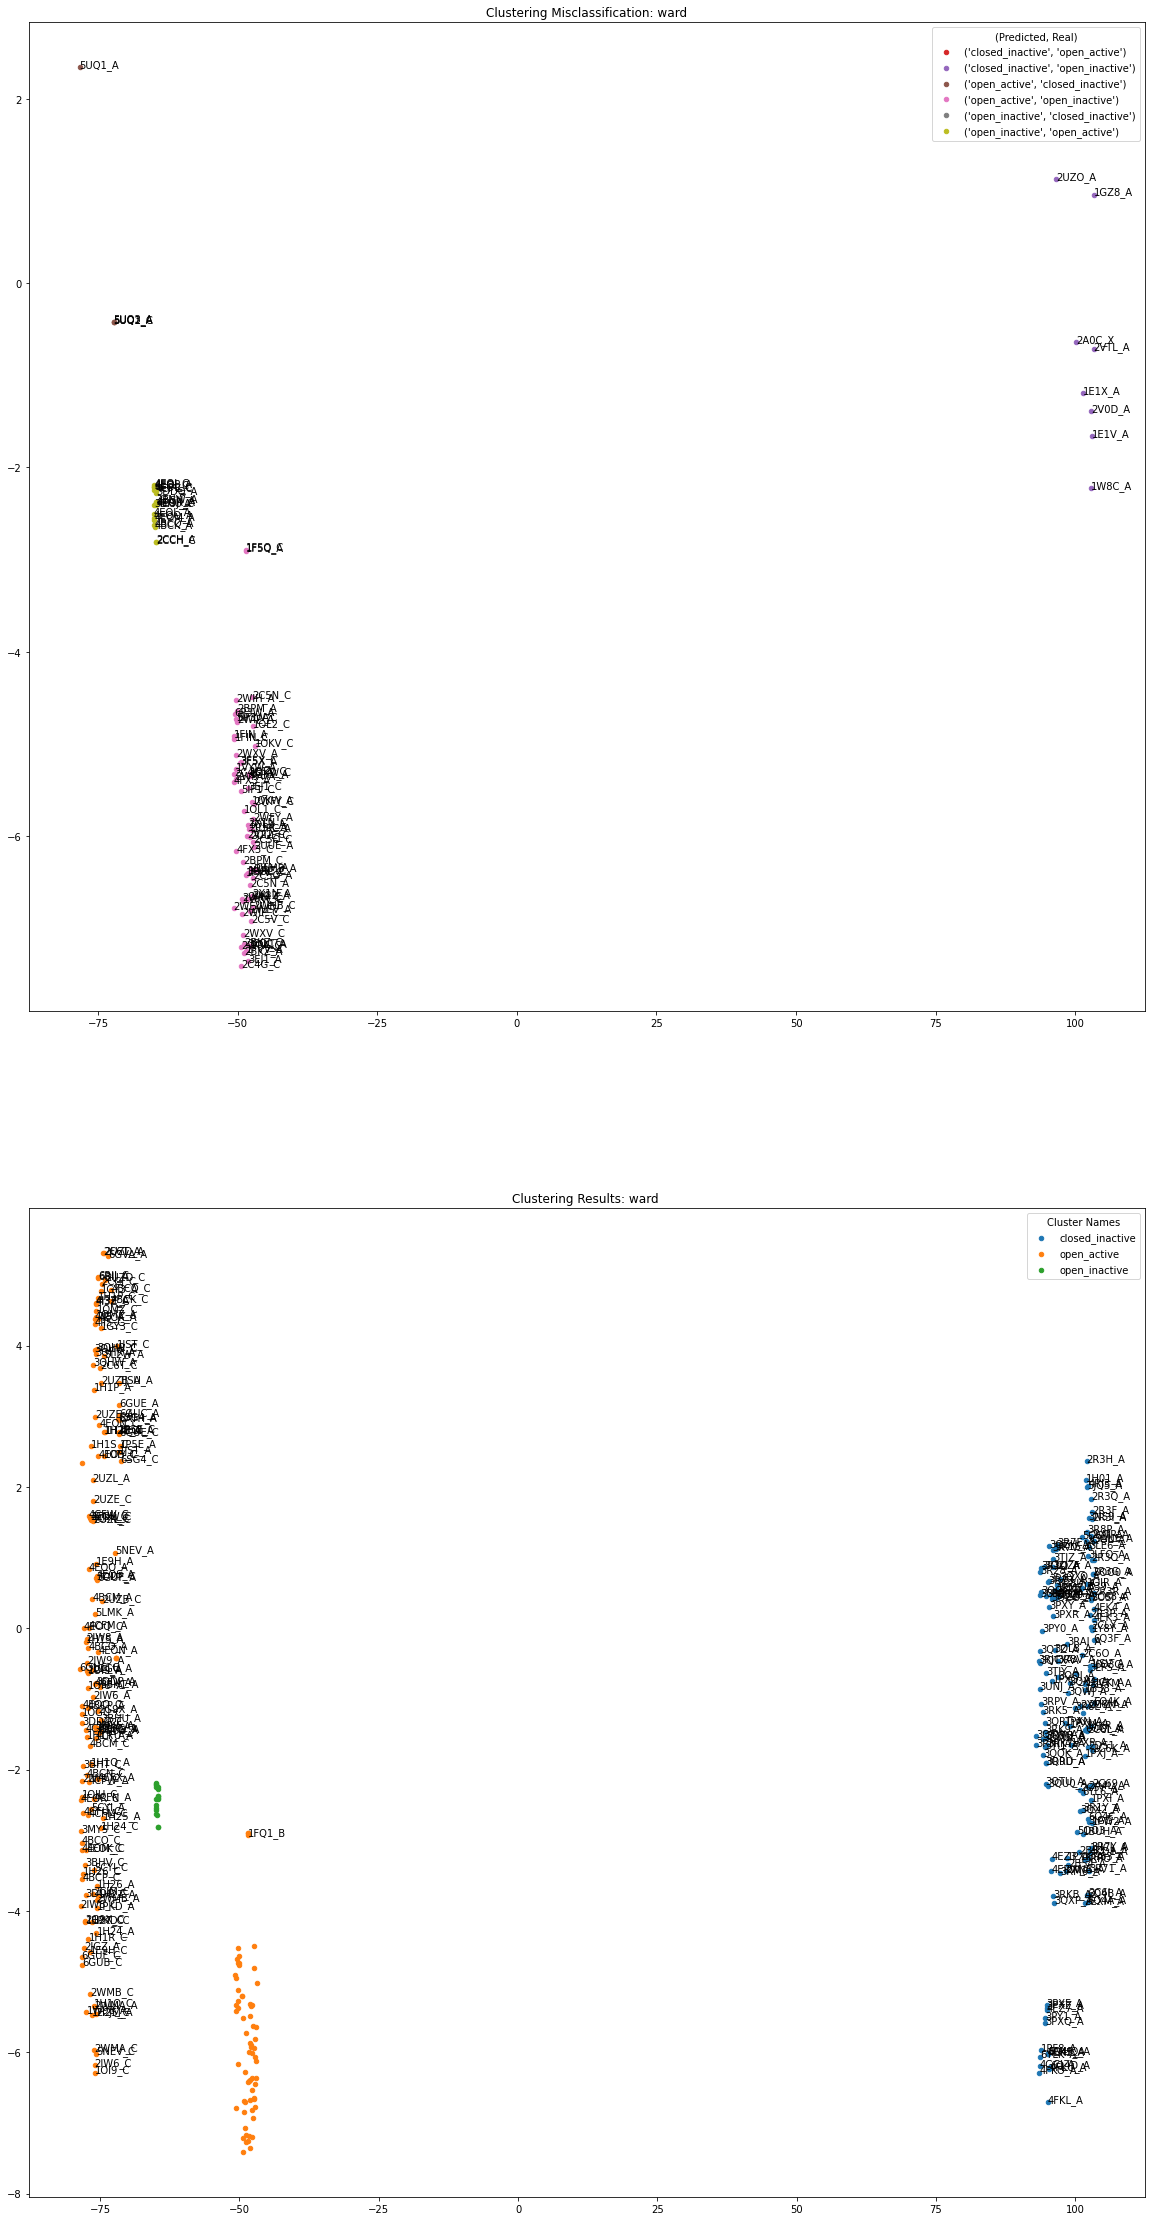

(#missing residues, percentage) [(0, 0.24675324675324675)]
miclassified_missing (list where value at i is amount of misclassified and i is amount of missing residues:
 [95]
totals_missing (list where value at i is number of conformations and i is amount of missing residues:
 [385]


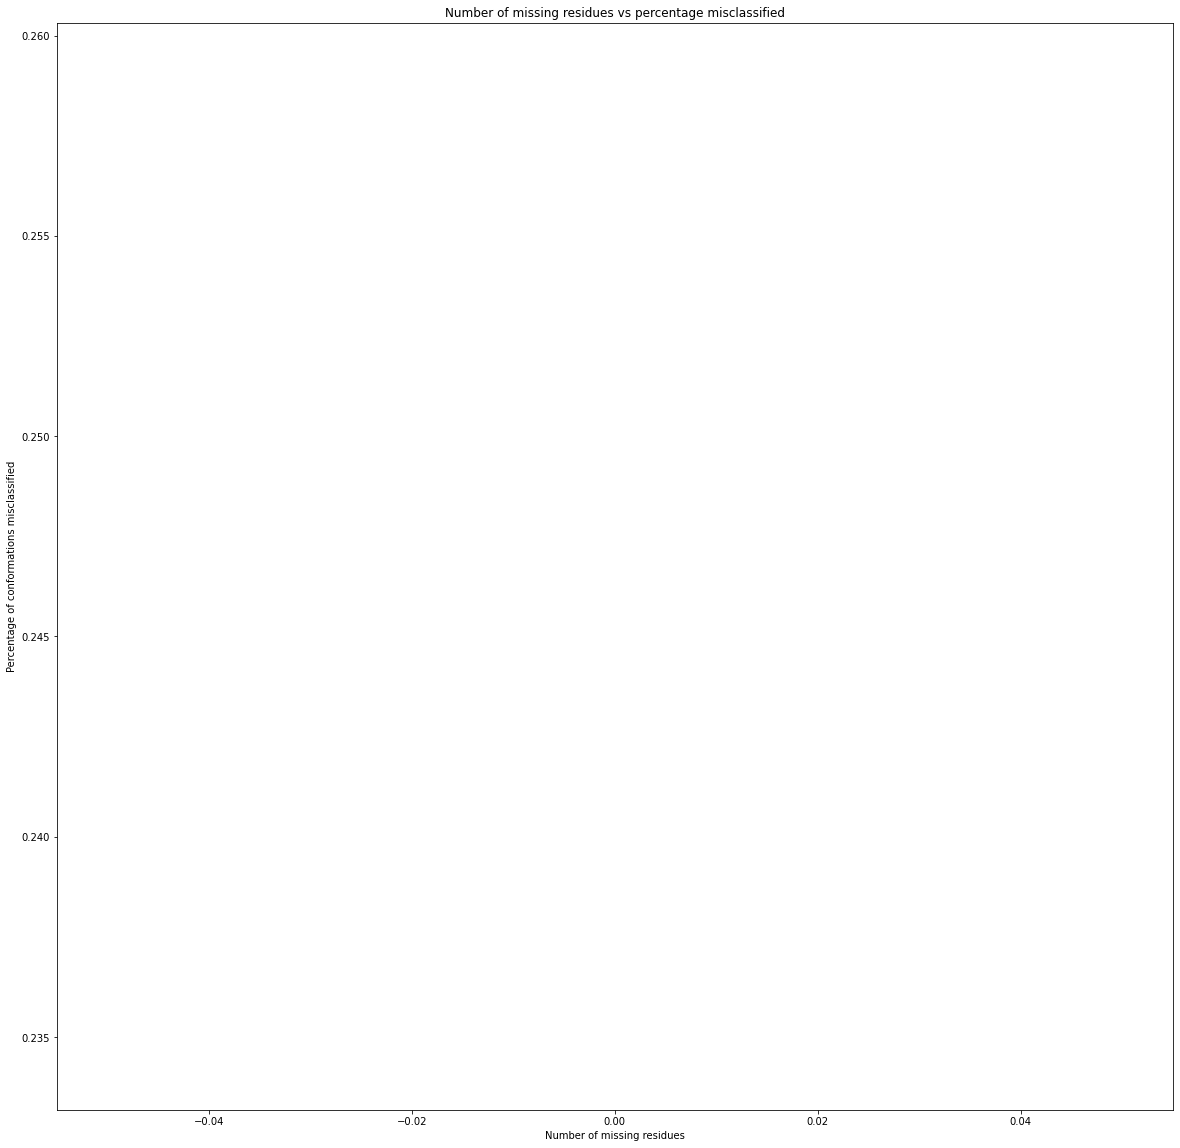

In [ ]:
stats_df5,cc_df5 = info(matrix_144to166,"Selected RMSD CA (143,165) no missing residues", reduced_chains_list,annotated_dict_list, complete = False, hierarchy_method = "ward", no_clusters=3,tsne=True)

In [ ]:
ex5_latex = stats_df5.to_latex()
print(f"ex5:\n {ex5_latex}")
ex5_cc_latex = cc_df5.to_latex()
print(f"ex5 cc:\n {ex5_cc_latex}")

ex5:
 \begin{tabular}{lrrr}
\toprule
{} &  Precision &    Recall &  F1 score \\
\midrule
closed\_inactive &   0.948718 &  0.973684 &  0.961039 \\
open\_active     &   0.672986 &  0.887500 &  0.765499 \\
open\_inactive   &   0.000000 &  0.000000 &       NaN \\
Averages        &   0.540568 &  0.620395 &       NaN \\
\bottomrule
\end{tabular}

ex5 cc:
 \begin{tabular}{lrrr}
\toprule
{} &  Real closed\_inactive &  Real open\_active &  Real open\_inactive \\
\midrule
Predicted closed\_inactive &                   148 &                 0 &                   8 \\
Predicted open\_active     &                     4 &               142 &                  65 \\
Predicted open\_inactive   &                     0 &                18 &                   0 \\
\bottomrule
\end{tabular}



## RMSD Full sequence without missing residues
It is only fair to compare full sequences without missing residues to Activation loop without missing residues
### Analysis:
The results are actually worse than with missing residues. Also the remaining 55 conformations after the removal of conformations with missing residues are not good representations of the rest of the filtered data

In [ ]:
threshold_remove(threshold=1, segments=[(0,297)])
with open("reduced_chains_list.var","rb") as reduced_chains_list_var:
   reduced_chains_list = pickle.load(reduced_chains_list_var)
   reduced_chains_list_var.close()
#print(f"chains_list: {chains_list}")
with open("structures/opened_active.var", "rb") as open_active_var:
    open_active_list = pickle.load(open_active_var)
    open_active_var.close()
with open("structures/closed_inactive.var", "rb") as closed_inactive_var:
    closed_inactive_list = pickle.load(closed_inactive_var)
    closed_inactive_var.close()
with open("structures/opened_inactive.var", "rb") as open_inactive_var:
    open_inactive_list = pickle.load(open_inactive_var)
    open_inactive_var.close()

print(f"open_active: {len(open_active_list)}")
print(f"closed_inactive: {len(closed_inactive_list)}")
print(f"open_inactive: {len(open_inactive_list)}")
annotated_dict_list_codes= {"open_active": open_active_list, "closed_inactive": closed_inactive_list, "open_inactive": open_inactive_list} #dictionary of codes list
annotated_dict_list ={"open_active": list(), "closed_inactive": list(), "open_inactive": list()} #dictionary of list of indices
for i,conformation in enumerate(reduced_chains_list):
    for j,l in enumerate(annotated_dict_list_codes):
        if conformation in annotated_dict_list_codes[l]:
            #print(f"l: {l}")
            annotated_dict_list[l].append(i)
print(f"reduced lengths")
for key in annotated_dict_list:
    print(f"{key}: {len(annotated_dict_list[key])}")

In [ ]:
stats_df, cc_df = info(matrix,"RMSD, CA no missing residues", reduced_chains_list,annotated_dict_list, complete= False, kernel="linear",hierarchy_method = "ward", no_clusters=3,tsne=True)